In [2]:
# Package installation
!pip install vaderSentiment
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [3]:
# Standard libraries
import os
import pickle
import random
import re
import warnings

# Data manipulation and mathematical libraries
import numpy as np
import pandas as pd

# Machine learning and preprocessing
from sklearn import metrics
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Natural Language Processing with NLTK
import nltk
from nltk import corpus, pos_tag
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import regexp_tokenize, sent_tokenize, word_tokenize

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud, get_single_color_func

# Deep Learning with TensorFlow and Keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.layers import (Conv1D, Dense, Embedding, GRU, GlobalMaxPooling1D,
                                     LSTM, SimpleRNN)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Other external libraries
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [6]:
#Get access to Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
! pip install -q kaggle
! mkdir ~/.kaggle

In [8]:
#Choose the kaggle.json file that you downloaded
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
# #UMICH SI650 - Sentiment Classification
# #https://www.kaggle.com/competitions/si650winter11/data
! kaggle competitions download -c si650winter11
! unzip si650winter11.zip -d si650winter11

  0% 0.00/506k [00:00<?, ?B/s]
100% 506k/506k [00:00<00:00, 113MB/s]
Archive:  si650winter11.zip
  inflating: si650winter11/testdata.txt  
  inflating: si650winter11/training.txt  


In [10]:
!mkdir models/

In [11]:
#Read test and train datasets
train_data_df  = pd.read_table('si650winter11/training.txt', names=['sentiment', 'comment'],
                               header=None, # header=0 -> first line contains column names
                               delimiter="\t", # delimiter=\t -> fields are separated by tabs
                               quoting=3) # quoting=3 -> ignore double quotes
test_data_df  = pd.read_table('si650winter11/testdata.txt', names=['comment'],
                              header=None, delimiter="\t", quoting=3)

In [12]:
test_data_df.head(5)

comment
0  " I don't care what anyone says, I like Hillar...
1                  have an awesome time at purdue!..
2  Yep, I'm still in London, which is pretty awes...
3  Have to say, I hate Paris Hilton's behavior bu...
4                            i will love the lakers.

In [13]:
train_data_df.head(5)

sentiment                                            comment
0          1            The Da Vinci Code book is just awesome.
1          1  this was the first clive cussler i've ever rea...
2          1                   i liked the Da Vinci Code a lot.
3          1                   i liked the Da Vinci Code a lot.
4          1  I liked the Da Vinci Code but it ultimatly did...

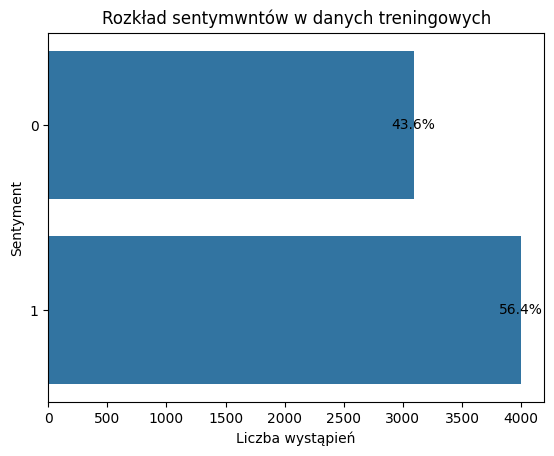

In [14]:
ax = sns.countplot(y="sentiment", data=train_data_df)
ax.set(title="Rozkład sentymwntów w danych treningowych", xlabel="Liczba wystąpień", ylabel="Sentyment")
total_freq = len(train_data_df)
for p in ax.patches:
    percentage = f'{100 * p.get_width() / total_freq:.1f}%'
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

In [15]:
#number words per sentence
np.mean([len(s.split(" ")) for s in train_data_df.comment])

10.886819079875812

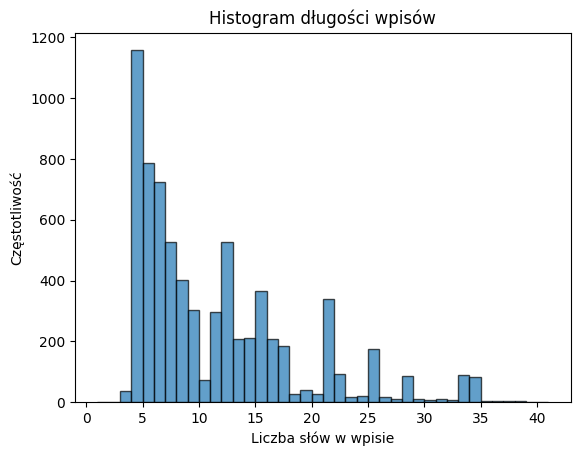

In [16]:
#Make a frequency list of lengths of tokenized each sentences
list_freq = [len(regexp_tokenize(s, "\w+")) for s in train_data_df["comment"]]

# Plot a histogram of the line lengths
#plt.figure(figsize=(8, 6))  # Ustawienie rozmiaru figury
plt.hist(list_freq, bins=range(1, max(list_freq) + 2), edgecolor='black', alpha=0.7)
plt.title("Histogram długości wpisów")
plt.xlabel("Liczba słów w wpisie")
plt.ylabel("Częstotliwość")
plt.show()

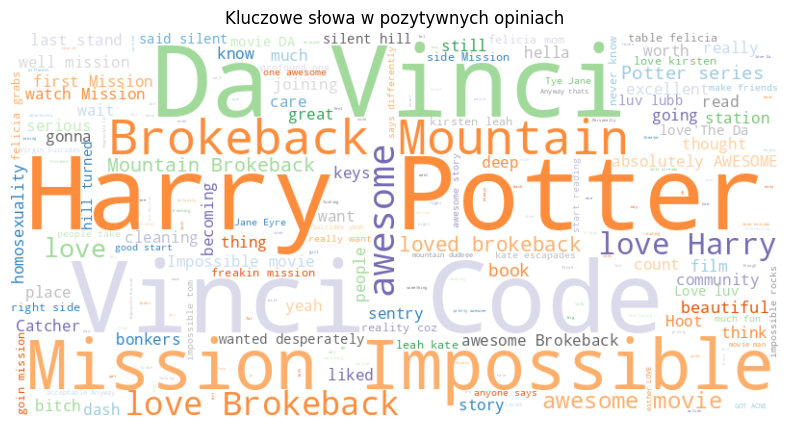

In [17]:
positive_comments = train_data_df[train_data_df['sentiment']==1]['comment']
text = " ".join(review for review in positive_comments)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab20c').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Kluczowe słowa w pozytywnych opiniach")
plt.axis('off')
plt.show()

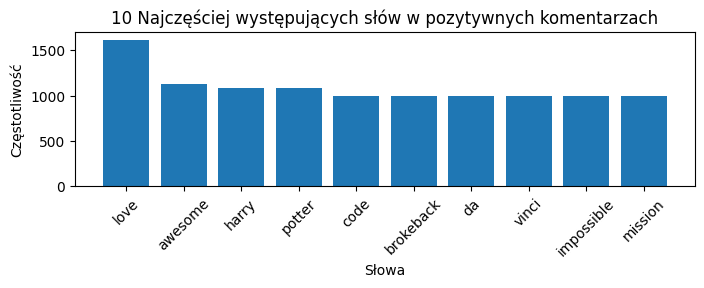

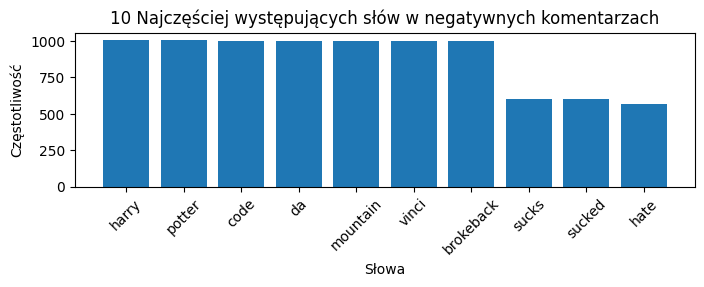

In [18]:
vectorizer = CountVectorizer(stop_words='english')

positive_comments = train_data_df[train_data_df['sentiment'] == 1]['comment']
positive_matrix = vectorizer.fit_transform(positive_comments)
positive_freq = zip(vectorizer.get_feature_names_out(), positive_matrix.sum(axis=0).tolist()[0])
positive_freq = sorted(positive_freq, key=lambda x: -x[1])

negative_comments = train_data_df[train_data_df['sentiment'] == 0]['comment']
negative_matrix = vectorizer.fit_transform(negative_comments)
negative_freq = zip(vectorizer.get_feature_names_out(), negative_matrix.sum(axis=0).tolist()[0])
negative_freq = sorted(negative_freq, key=lambda x: -x[1])

#Create histogram for top frequent words in positive comments
labels_pos, values_pos = zip(*positive_freq[:10])
plt.figure(figsize=(8,2))
plt.bar(labels_pos, values_pos)
plt.title('10 Najczęściej występujących słów w pozytywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()
#Create histogram for top frequent words in negative comments
labels_neg, values_neg = zip(*negative_freq[:10])
plt.figure(figsize=(8,2))
plt.bar(labels_neg, values_neg)
plt.title('10 Najczęściej występujących słów w negatywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()

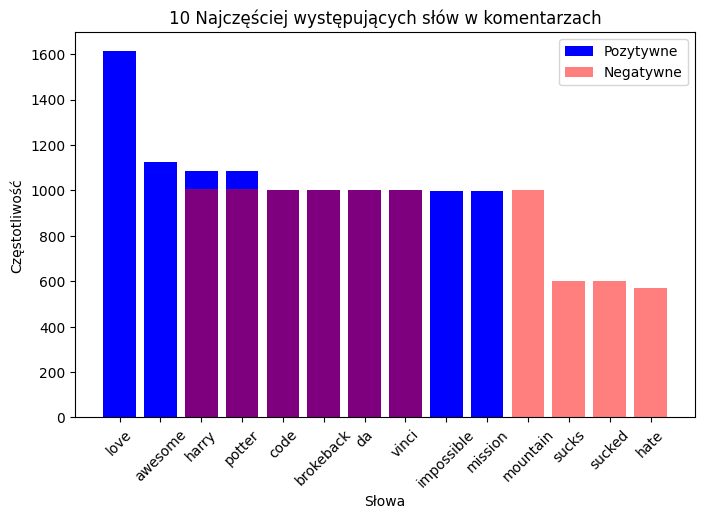

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels_pos, values_pos, color='blue', label='Pozytywne')
ax.bar(labels_neg, values_neg, color='red', label='Negatywne', alpha=0.5)
ax.set_title('10 Najczęściej występujących słów w komentarzach')
ax.set_ylabel('Częstotliwość')
ax.set_xlabel('Słowa')
ax.legend()
plt.xticks(rotation=45)
plt.show()

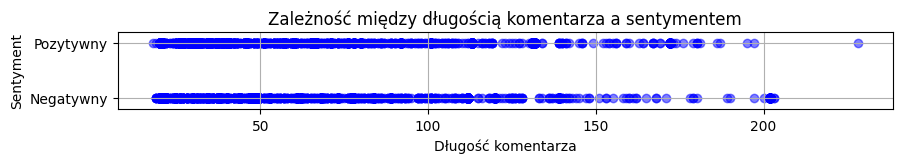

In [20]:
plt.figure(figsize=(10, 1))
plt.scatter(train_data_df['comment'].apply(len), train_data_df['sentiment'], color='blue', alpha=0.5)  # Set transparency for better visibility when points overlap
plt.title('Zależność między długością komentarza a sentymentem')
plt.xlabel('Długość komentarza')
plt.ylabel('Sentyment')
plt.yticks([0, 1], ["Negatywny", "Pozytywny"])
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.show()

In [21]:
#Dictionary to store sentiment lists for every word
sentiment_dict = defaultdict(list)

rows = []
for _, row in train_data_df.iterrows():
    words = row['comment'].lower().split()
    for word in words:
        sentiment_dict[word].append(row['sentiment'])

def determine_color(sentiments):
    if all(s == 1 for s in sentiments):
        return 'green'
    elif all(s == 0 for s in sentiments):
        return 'red'
    else:
        return 'orange'

color_dict = {word: determine_color(sentiments) for word, sentiments in sentiment_dict.items()}

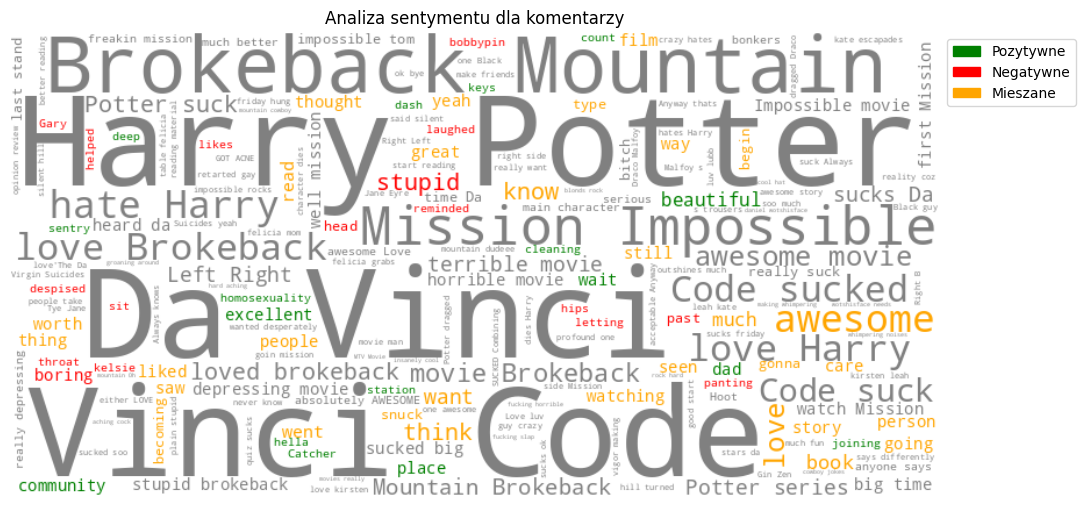

In [22]:
#Function color_func use color dictionary
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return color_dict.get(word.lower(), 'grey')

text = ' '.join(train_data_df['comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(text)
legend_elements = [
    mpatches.Patch(color='green', label='Pozytywne'),
    mpatches.Patch(color='red', label='Negatywne'),
    mpatches.Patch(color='orange', label='Mieszane')
]
plt.figure(figsize=(12, 7))
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Analiza sentymentu dla komentarzy')
plt.axis('off')
plt.show()


In [23]:
#Preprocessing

In [24]:
def stem_tokens(tokens, stemmer):
  return [stemmer.stem(item) for item in tokens]

def tokenize(text):
  text = re.sub("[^a-zA-Z]", " ", text) #remove non letters
  tokens = nltk.word_tokenize(text) #tokenize
  stems = stem_tokens(tokens, PorterStemmer()) #stem
  return stems

In [25]:
count_vect = CountVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, max_features=100, token_pattern=None)
#fits the model, model learns the vocabulary and transforms corpus data into feature vectors
comment_tf = count_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
#to numpy
comment_tf_nd = comment_tf.toarray()
comment_tf_nd.shape

(40138, 100)

In [26]:
print("Comments term frequency (CountVectorize): ")
pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out()).head(5)

Comments term frequency (CountVectorize): 


a  aaa  about  an  and  angelina  are  as  at  awesom  ...  wa  want  way  \
0  0    0      0   0    0         0    0   0   0       1  ...   0     0    0   
1  0    0      0   0    1         0    0   0   0       0  ...   1     0    0   
2  1    0      0   0    0         0    0   0   0       0  ...   0     0    0   
3  1    0      0   0    0         0    0   0   0       0  ...   0     0    0   
4  0    0      0   0    0         0    0   0   0       0  ...   0     0    0   

   we  when  which  who  with  would  you  
0   0     0      0    0     0      0    0  
1   0     0      0    0     0      0    0  
2   0     0      0    0     0      0    0  
3   0     0      0    0     0      0    0  
4   0     0      0    0     0      0    0  

[5 rows x 100 columns]

In [27]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, max_features=100, smooth_idf=False, token_pattern=None)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
print(comment_tfidf_nd.shape)

(40138, 100)


In [28]:
print("Comments term frequency-inverse document frequency (tf-idf):")
pd.DataFrame(comment_tfidf_nd, columns=tfidf_vect.get_feature_names_out()).head(5)

Comments term frequency-inverse document frequency (tf-idf):


a  aaa  about   an       and  angelina  are   as   at    awesom  \
0  0.000000  0.0    0.0  0.0  0.000000       0.0  0.0  0.0  0.0  0.365473   
1  0.000000  0.0    0.0  0.0  0.168531       0.0  0.0  0.0  0.0  0.000000   
2  0.325089  0.0    0.0  0.0  0.000000       0.0  0.0  0.0  0.0  0.000000   
3  0.325089  0.0    0.0  0.0  0.000000       0.0  0.0  0.0  0.0  0.000000   
4  0.000000  0.0    0.0  0.0  0.000000       0.0  0.0  0.0  0.0  0.000000   

   ...        wa  want  way   we  when  which  who  with  would  you  
0  ...  0.000000   0.0  0.0  0.0   0.0    0.0  0.0   0.0    0.0  0.0  
1  ...  0.228514   0.0  0.0  0.0   0.0    0.0  0.0   0.0    0.0  0.0  
2  ...  0.000000   0.0  0.0  0.0   0.0    0.0  0.0   0.0    0.0  0.0  
3  ...  0.000000   0.0  0.0  0.0   0.0    0.0  0.0   0.0    0.0  0.0  
4  ...  0.000000   0.0  0.0  0.0   0.0    0.0  0.0   0.0    0.0  0.0  

[5 rows x 100 columns]

In [29]:
#words in vocabulary
vocab = count_vect.get_feature_names_out()
print(vocab)

['a' 'aaa' 'about' 'an' 'and' 'angelina' 'are' 'as' 'at' 'awesom' 'be'
 'beauti' 'becaus' 'been' 'boston' 'brokeback' 'but' 'by' 'can' 'code'
 'cruis' 'da' 'even' 'for' 'francisco' 'geico' 'go' 'great' 'harri'
 'harvard' 'hate' 'have' 'he' 'hilton' 'honda' 'i' 'imposs' 'in' 'is' 'it'
 'joli' 'just' 'laker' 'like' 'london' 'love' 'm' 'macbook' 'me' 'miss'
 'mission' 'mit' 'more' 'mountain' 'movi' 'much' 'my' 'need' 'not' 'of'
 'on' 'one' 'or' 'out' 'pari' 'peopl' 'potter' 'purdu' 'realli' 's' 'san'
 'seattl' 'shanghai' 'so' 'still' 'stupid' 'suck' 't' 'than' 'that' 'the'
 'thi' 'think' 'to' 'tom' 'too' 'toyota' 'ucla' 'up' 'vinci' 'wa' 'want'
 'way' 'we' 'when' 'which' 'who' 'with' 'would' 'you']


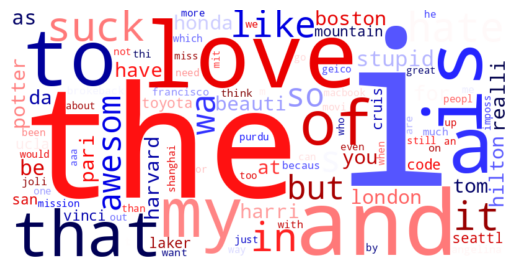

In [30]:
sum_vocab = np.sum(comment_tf_nd, axis=0)
word_frequencies = dict(zip(vocab, sum_vocab))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='seismic',).generate_from_frequencies(word_frequencies)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Classification**

In [31]:
model_metrics = {}
model_metrics_temp = {}

def add_model_metrics(model_name, y_test, y_pred, y_probs, dict_name = "final"):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_probs)
    pr_auc = metrics.auc(recall, precision)

    if dict_name == "final":
      model_metrics[model_name] = {
        'y_pred' : y_pred,
        'y_probs' : y_probs,
        'auc': metrics.roc_auc_score(y_test, y_probs),
        'precision': metrics.precision_score(y_test, y_pred),
        'recall': metrics.recall_score(y_test, y_pred),
        'f1_score': metrics.f1_score(y_test, y_pred),
        'roc_auc': metrics.roc_auc_score(y_test, y_pred),
        'pr_auc': pr_auc,
        'log_loss': metrics.log_loss(y_test, y_probs)
      }
    if dict_name == "selection":
      model_metrics_temp[model_name] = {
          'y_pred' : y_pred,
          'y_probs' : y_probs,
          'auc': metrics.roc_auc_score(y_test, y_probs),
          'precision': metrics.precision_score(y_test, y_pred),
          'recall': metrics.recall_score(y_test, y_pred),
          'f1_score': metrics.f1_score(y_test, y_pred),
          'roc_auc': metrics.roc_auc_score(y_test, y_pred),
          'pr_auc': pr_auc,
          'log_loss': metrics.log_loss(y_test, y_probs)
      }

In [32]:
def calculate_weighted_score(metrics, weights):
    total_weight = sum(weights.values())
    aggregated_score = sum(metrics[metric] * weights[metric] for metric in metrics if metric in weights)

    if total_weight == 0:
        raise ValueError("The sum of the weights cannot be equal to zero.")

    return aggregated_score / total_weight

In [33]:
def calculate_aggregated_metric_from_dict(data, weights):
    normalized_data = {key.capitalize(): value for key, value in data.items() if key.capitalize() in weights}
    return calculate_weighted_score(normalized_data, weights)

In [34]:
def select_best_model(model_metrics_temp=model_metrics_temp, drop = False):
  best_model = None
  best_score = -float('inf')
  best_model_metrics = {}

  for model_name, model_measures in model_metrics_temp.items():
    weights = {'Precision': 0.2, 'Recall': 0.2, 'F1 Score': 0.3, 'Auc': 0.2}
    normalized_measures = {key.capitalize(): value for key, value in model_measures.items() if key.capitalize() in weights}

    # Normalize keys and calculate the score using weighted sum of the selected metrics
    score = calculate_aggregated_metric_from_dict(normalized_measures, weights)
    print("Model name: ", model_name, "-> SCORE: ", score)

    # Check if this model has a higher score
    if score > best_score:
      best_score = score
      best_model = model_name
      best_model_metrics = model_measures

  # Display the best model's metrics
  if best_model:
    print(f"Selected best model: {best_model}")
    model_metrics[best_model] = best_model_metrics
    print("Best model metrics:")
    print(*(f"{k}: {v}" for k, v in list(best_model_metrics.items())[2:]), sep="\n")
    if drop == True:
      model_metrics_temp.clear()
  else:
    print("No valid models were found.")

In [35]:
select_best_model()

No valid models were found.


In [36]:
# find some good and bad words
df = pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out())
selected_words = ['awesom', 'good', 'great', 'like', 'shitti', 'stupid', 'suck']
sum_data = dict()

for word in selected_words:
  if word in df.columns.to_list():
    sum_data[word] = df[word].sum()
  else:
    print("Word:", word, "not within the list")
print("Word frequency:", sum_data)

Word: good not within the list
Word: shitti not within the list
Word frequency: {'awesom': 3170, 'great': 1178, 'like': 4080, 'stupid': 2886, 'suck': 4614}


In [37]:
#sum_data
df_subset = df[sum_data.keys()]
X_train, X_test, y_train, y_test  = train_test_split(df_subset[0:len(train_data_df)], train_data_df.sentiment,
                                                     train_size=0.75, random_state=1,
                                                     stratify=train_data_df.sentiment)

# **Logistic Regression**

In [38]:
# Suppress ConvergenceWarnings
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [39]:
# Setup the pipeline
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

# Parameter grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Values of C (inverse of regularization strength)
    'logisticregression__penalty': ['l1', 'l2'],  # Types of regularization
    'logisticregression__solver': ['liblinear', 'saga']  # Solvers that support L1 regularization
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',
    verbose=1
)

# Fitting grid search
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_model_log_sw = grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


In [40]:
y_pred = best_model_log_sw.predict(X=X_test)
y_pred_prob_sw = best_model_log_sw.predict_proba(X=X_test)[:,1]
fpr_sw, tpr_sw, thresholds = metrics.roc_curve(y_test, y_pred_prob_sw)
roc_auc_sw = metrics.auc(fpr_sw, tpr_sw)

In [41]:
add_model_metrics('log_sw', y_test, y_pred, y_pred_prob_sw, "selection")

In [42]:
# Saving the best model obtained from grid search
with open('models/log_sw.pkl', 'wb') as f:
    pickle.dump(best_model_log_sw, f)

In [43]:
#tf-idf linear classifier - train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(comment_tfidf_nd[0:len(train_data_df)], train_data_df.sentiment,
                                                                             train_size=0.75, random_state=1, stratify=train_data_df.sentiment)

In [44]:
# Split the dataset into training and testing sets
X = train_data_df['comment']
y = train_data_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Setup the pipeline
pipeline = make_pipeline(TfidfVectorizer(), StandardScaler(with_mean=False), LogisticRegression())

# Parameter grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Values of C (inverse of regularization strength)
    'logisticregression__penalty': ['l1', 'l2'],  # Types of regularization
    'logisticregression__solver': ['liblinear', 'saga']  # Solvers that support L1 regularization
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',
    verbose=1
)

# Fitting grid search
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_model_lr_ss_tfidf = grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'logisticregression__C': 1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [46]:
# Predictions with the best model
y_pred_lr_ss_tfidf = best_model_lr_ss_tfidf.predict(X=X_test)
y_pred_prob_lr_ss_tfidf = best_model_lr_ss_tfidf.predict_proba(X=X_test)[:, 1]
print(metrics.classification_report(y_test, y_pred_lr_ss_tfidf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       626
           1       0.99      0.99      0.99       792

    accuracy                           0.99      1418
   macro avg       0.99      0.99      0.99      1418
weighted avg       0.99      0.99      0.99      1418



In [47]:
fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, thresholds = metrics.roc_curve(y_test, y_pred_prob_lr_ss_tfidf)
roc_auc_lr_ss_tfidf = metrics.auc(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf)
roc_auc_lr_ss_tfidf

0.9995199599832189

In [48]:
add_model_metrics('logreg_standscal_tfidf', y_test, y_pred_lr_ss_tfidf, y_pred_prob_lr_ss_tfidf, "selection")

In [49]:
# Saving the best model obtained from grid search
with open('models/logreg_standscal_tfidf.pkl', 'wb') as f:
    pickle.dump(best_model_lr_ss_tfidf, f)

In [50]:
# Setup the pipeline
pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression())

# Parameter grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Values of C (inverse of regularization strength)
    'logisticregression__penalty': ['l1', 'l2'],  # Types of regularization
    'logisticregression__solver': ['liblinear', 'saga']  # Solvers that support L1 regularization
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',
    verbose=1
)

# Fitting grid search
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_model_lr_tfidf = grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'logisticregression__C': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


In [51]:
# Predictions with the best model
y_pred_lr_tfidf = best_model_lr_tfidf.predict(X=X_test)
y_pred_prob_lr_tfidf = best_model_lr_tfidf.predict_proba(X=X_test)[:, 1]
print(metrics.classification_report(y_test, y_pred_lr_tfidf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       626
           1       0.99      0.99      0.99       792

    accuracy                           0.99      1418
   macro avg       0.99      0.99      0.99      1418
weighted avg       0.99      0.99      0.99      1418



In [52]:
fpr_lr_tfidf, tpr_lr_tfidf, thresholds = metrics.roc_curve(y_test, y_pred_prob_lr_tfidf)
roc_auc_lr_tfidf = metrics.auc(fpr_lr_tfidf, tpr_lr_tfidf)

In [53]:
add_model_metrics('logreg_tfidf', y_test, y_pred_lr_tfidf, y_pred_prob_lr_tfidf, "selection")

In [54]:
# Saving the best model obtained from grid search
with open('models/logreg_tfidf.pkl', 'wb') as f:
    pickle.dump(best_model_lr_tfidf, f)

In [55]:
# Setup the pipeline with CountVectorizer
pipeline = make_pipeline(
    CountVectorizer(),
    StandardScaler(with_mean=False),  # Necessary for handling sparse matrices
    LogisticRegression()
)

# Parameter grid for GridSearchCV
param_grid = {
    'countvectorizer__max_features': [1000, 5000, 10000],
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1
)

# Fitting grid search
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_model_lr_ss_tf = grid_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'countvectorizer__max_features': 10000, 'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [56]:
# Predictions with the best model
y_pred_lr_ss_tf = best_model_lr_ss_tf.predict(X_test)
y_pred_prob_lr_ss_tf = best_model_lr_ss_tf.predict_proba(X_test)[:, 1]
print(metrics.classification_report(y_test, y_pred_lr_ss_tf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       626
           1       0.99      0.99      0.99       792

    accuracy                           0.99      1418
   macro avg       0.99      0.99      0.99      1418
weighted avg       0.99      0.99      0.99      1418



In [57]:
fpr_lr_ss_tf, tpr_lr_ss_tf, thresholds = metrics.roc_curve(y_test, y_pred_prob_lr_ss_tf)
roc_auc_lr_ss_tf = metrics.auc(fpr_lr_ss_tf, tpr_lr_ss_tf)

In [58]:
add_model_metrics('logreg_standardscaler_tf', y_test, y_pred_lr_ss_tf, y_pred_prob_lr_ss_tf, "selection")

In [59]:
# Saving the best model obtained from grid search
with open('models/logreg_standardscaler_tf.pkl', 'wb') as f:
    pickle.dump(best_model_lr_ss_tf, f)

In [60]:
# Setup the pipeline with CountVectorizer
pipeline = make_pipeline(
    CountVectorizer(),  # Necessary for handling sparse matrices
    LogisticRegression()
)

# Parameter grid for GridSearchCV
param_grid = {
    'countvectorizer__max_features': [1000, 5000, 10000],  # Optional: limit the number of features
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1
)

# Fitting grid search
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_model_lr_tf = grid_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'countvectorizer__max_features': 5000, 'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


In [61]:
# Predictions with the best model
y_pred_lr_tf = best_model_lr_tf.predict(X_test)
y_pred_prob_lr_tf = best_model_lr_tf.predict_proba(X_test)[:, 1]
print(metrics.classification_report(y_test, y_pred_lr_tf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       626
           1       0.99      0.99      0.99       792

    accuracy                           0.99      1418
   macro avg       0.99      0.99      0.99      1418
weighted avg       0.99      0.99      0.99      1418



In [62]:
fpr_lr_tf, tpr_lr_tf, thresholds = metrics.roc_curve(y_test, y_pred_prob_lr_tf)
roc_auc_lr_tf = metrics.auc(fpr_lr_tf, tpr_lr_tf)

In [63]:
add_model_metrics('logreg_tf', y_test, y_pred_lr_tf, y_pred_prob_lr_tf, "selection")

In [64]:
# Saving the best model obtained from grid search
with open('models/logreg_tf.pkl', 'wb') as f:
    pickle.dump(best_model_lr_tf, f)

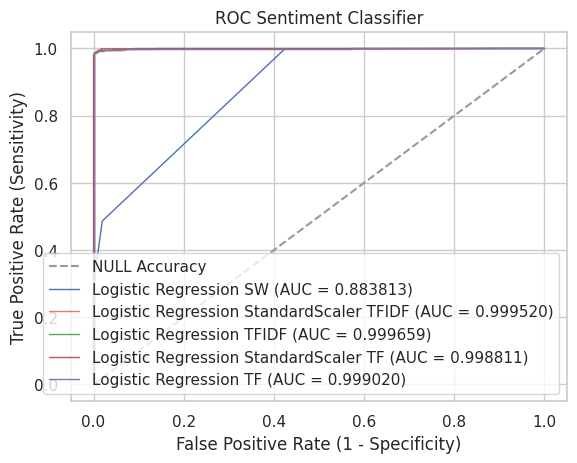

In [65]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

**Select the best Logistic Regression model** </br>
**Calculate the mean of the metrics for each model and finds the model with the best (highest) score**



In [66]:
#Choose the best model
select_best_model()

Model name:  log_sw -> SCORE:  0.5856558172549684
Model name:  logreg_standscal_tfidf -> SCORE:  0.6634693039229053
Model name:  logreg_tfidf -> SCORE:  0.6635002308707652
Model name:  logreg_standardscaler_tf -> SCORE:  0.6621872876041112
Model name:  logreg_tf -> SCORE:  0.6630818300147374
Selected best model: logreg_tfidf
Best model metrics:
auc: 0.9996591312485882
precision: 0.9949302915082383
recall: 0.9911616161616161
f1_score: 0.9930423782416192
roc_auc: 0.9923859199018943
pr_auc: 0.9997395649273481
log_loss: 0.023351398936685495


# **VADER SentimentIntensityAnalyzer**

In [68]:
vader_data_df = train_data_df
sia = SentimentIntensityAnalyzer()

vader_data_df['vader_score'] = vader_data_df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
vader_data_df['vader_pred'] = vader_data_df['vader_score'].apply(lambda x: 1 if x >= 0 else 0)

In [69]:
fpr_vader, tpr_vader, thresholds_vader = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_score'])
roc_auc_vader = metrics.auc(fpr_vader, tpr_vader)
roc_auc_vader

0.9561618393098135

In [70]:
add_model_metrics('VADER', vader_data_df['sentiment'], vader_data_df['vader_pred'], vader_data_df['vader_score'], "selection")

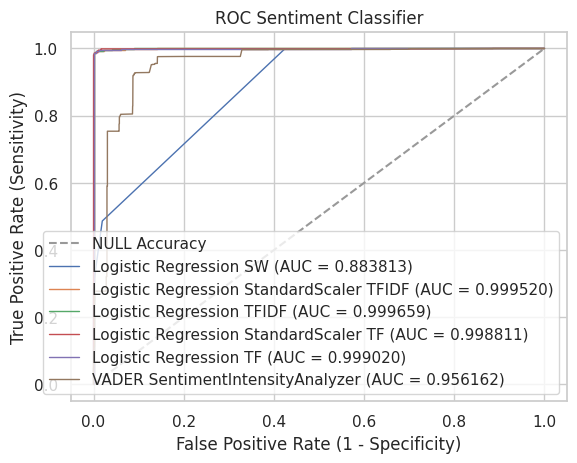

In [71]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [72]:
#Lemmatization with VADER (Lemmatization without specifying the part of speech)
#Lemmatize the entire text without dividing it into sentences -> This simplifies the process, but may not take into account some of the linguistic nuances that arise from sentence structure.

def lemmatize_text(text):
  lemmatizer = WordNetLemmatizer()
  word_tokens = word_tokenize(text)
  return ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])

In [73]:
tf.get_logger().setLevel('ERROR')  # Ignore anything less severe than ERROR
vader_lemmatizer_data_df = train_data_df
sia_lemmatizer = SentimentIntensityAnalyzer()

vader_lemmatizer_data_df['lemmatized_comment'] = vader_lemmatizer_data_df['comment'].apply(lemmatize_text)
vader_lemmatizer_data_df['vader_lemma_score'] = vader_lemmatizer_data_df['lemmatized_comment'].apply(lambda x: sia_lemmatizer.polarity_scores(x)['compound'])
vader_lemmatizer_data_df['vader_lemma_pred'] = vader_lemmatizer_data_df['vader_lemma_score'].apply(lambda x: 1 if x >= 0 else 0)

In [74]:
fpr_vader_lemmatizer, tpr_vader_lemmatizer, thresholds = metrics.roc_curve(vader_lemmatizer_data_df['sentiment'], vader_lemmatizer_data_df['vader_score'])
roc_auc_vader_lemmatizer = metrics.auc(fpr_vader_lemmatizer, tpr_vader_lemmatizer)

In [75]:
add_model_metrics('VADER_Lemma', vader_lemmatizer_data_df['sentiment'], vader_lemmatizer_data_df['vader_lemma_pred'],
                  vader_lemmatizer_data_df['vader_lemma_score'], "selection")

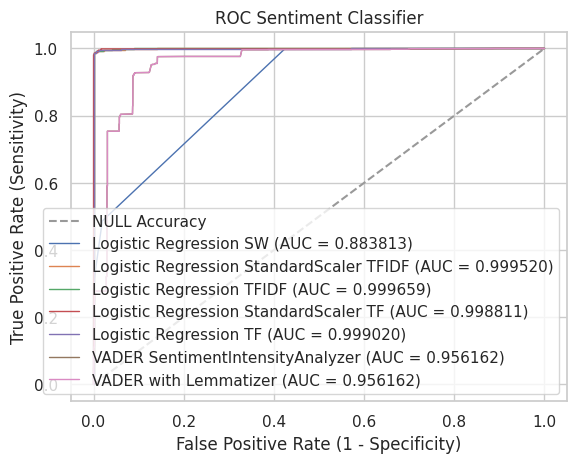

In [76]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_vader_lemmatizer, tpr_vader_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_vader_lemmatizer)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [77]:
def lemmatize_text(text):
  lemmatizer = WordNetLemmatizer() # Initialize the WordNetLemmatizer
  sentences = sent_tokenize(text) # Tokenize the text into sentences
  lemmatized_text = []
  for sentence in sentences:
    words = word_tokenize(sentence)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    lemmatized_text.append(' '.join(lemmatized_words))

  return ' '.join(lemmatized_text) # Join the lemmatized sentences back into a single string

In [78]:
vader_lemma_div_data_df = train_data_df
sia_vader_lemma_div = SentimentIntensityAnalyzer()

vader_lemma_div_data_df['vader_lemma_div_comment'] = vader_lemma_div_data_df['comment'].apply(lemmatize_text)
vader_lemma_div_data_df['vader_lemma_div_score'] = vader_lemma_div_data_df['vader_lemma_div_comment'].apply(lambda x: sia_vader_lemma_div.polarity_scores(x)['compound'])
vader_lemma_div_data_df['vader_lemma_div_pred'] = vader_lemma_div_data_df['vader_lemma_div_score'].apply(lambda x: 1 if x >= 0 else 0)


In [79]:
fpr_vader_lemma_div, tpr_vader_lemma_div, thresholds = metrics.roc_curve(vader_lemma_div_data_df['sentiment'], vader_lemma_div_data_df['vader_lemma_div_score'])
roc_auc_vader_lemma_div = metrics.auc(fpr_vader_lemma_div, tpr_vader_lemma_div)

In [80]:
add_model_metrics('VADER_Lemma_Div', vader_lemma_div_data_df['sentiment'], vader_lemma_div_data_df['vader_lemma_div_pred'],
                  vader_lemma_div_data_df['vader_lemma_div_score'], "selection")

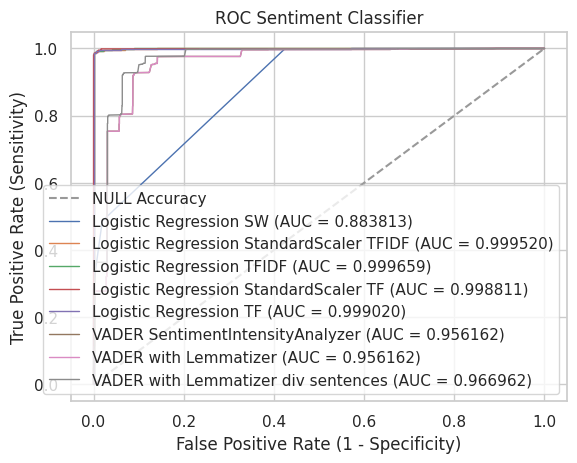

In [81]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_vader_lemmatizer, tpr_vader_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_vader_lemmatizer)
plt.plot(fpr_vader_lemma_div, tpr_vader_lemma_div, lw=1, label='VADER with Lemmatizer div sentences (AUC = %0.6f)' % roc_auc_vader_lemma_div)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [82]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
  """
  Function to map NLTK POS tags to WordNet POS tags - Map NLTK POS tag to a format recognized by WordNetLemmatizer.
  """
  tag = pos_tag([word])[0][1][0].upper()  # Get the first character of the POS tag
  tag_dict = {
      "J": corpus.wordnet.ADJ,
      "N": corpus.wordnet.NOUN,
      "V": corpus.wordnet.VERB,
      "R": corpus.wordnet.ADV
      }
  return tag_dict.get(tag, corpus.wordnet.NOUN)  # Default to noun if no match

def lemmatize_text(text):
  """
  Function to lemmatize text with proper POS tagging - Lemmatize text with POS tag mapping for better accuracy.
  """
  sentences = sent_tokenize(text)
  lemmatized_text = []
  for sentence in sentences:
    words = word_tokenize(sentence)
    lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words])
    lemmatized_text.append(lemmatized_sentence)
  return ' '.join(lemmatized_text)

In [83]:
vader_lemma2_data_df = train_data_df
sia_vader_lemma2 = SentimentIntensityAnalyzer()

vader_lemma2_data_df['vader_lemma2_comment'] = vader_lemma2_data_df['comment'].apply(lemmatize_text)
vader_lemma2_data_df['vader_lemma2_score'] = vader_lemma2_data_df['vader_lemma2_comment'].apply(lambda x: sia_vader_lemma2.polarity_scores(x)['compound'])
vader_lemma2_data_df['vader_lemma2_pred'] = vader_lemma2_data_df['vader_lemma2_score'].apply(lambda x: 1 if x >= 0 else 0)

In [84]:
fpr_vader_lemma2, tpr_vader_lemma2, thresholds = metrics.roc_curve(vader_lemma2_data_df['sentiment'], vader_lemma2_data_df['vader_lemma2_score'])
roc_auc_vader_lemma2 = metrics.auc(fpr_vader_lemma2, tpr_vader_lemma2)

In [85]:
add_model_metrics('VADER_Lemma2', vader_lemma2_data_df['sentiment'], vader_lemma2_data_df['vader_lemma2_pred'],
                  vader_lemma2_data_df['vader_lemma2_score'], "selection")

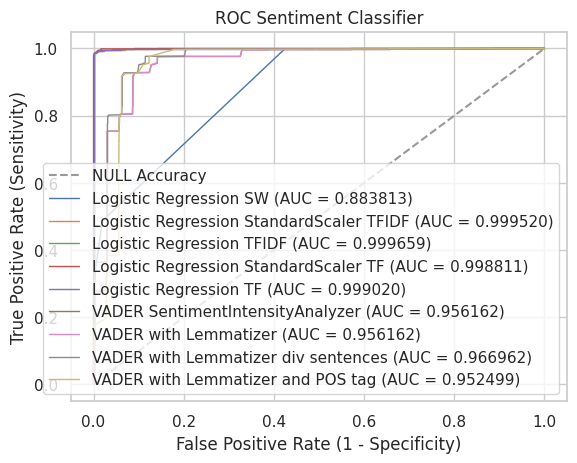

In [86]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_vader_lemmatizer, tpr_vader_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_vader_lemmatizer)
plt.plot(fpr_vader_lemma_div, tpr_vader_lemma_div, lw=1, label='VADER with Lemmatizer div sentences (AUC = %0.6f)' % roc_auc_vader_lemma_div)
plt.plot(fpr_vader_lemma2, tpr_vader_lemma2, lw=1, label='VADER with Lemmatizer and POS tag (AUC = %0.6f)' % roc_auc_vader_lemma2)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

**Calculate the mean of the metrics for each model and finds the model with the best (highest) score**

In [87]:
#Choose the best model
select_best_model()

Model name:  log_sw -> SCORE:  0.5856558172549684
Model name:  logreg_standscal_tfidf -> SCORE:  0.6634693039229053
Model name:  logreg_tfidf -> SCORE:  0.6635002308707652
Model name:  logreg_standardscaler_tf -> SCORE:  0.6621872876041112
Model name:  logreg_tf -> SCORE:  0.6630818300147374
Model name:  VADER -> SCORE:  0.625226848375504
Model name:  VADER_Lemma -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma_Div -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma2 -> SCORE:  0.6272431514493263
Selected best model: logreg_tfidf
Best model metrics:
auc: 0.9996591312485882
precision: 0.9949302915082383
recall: 0.9911616161616161
f1_score: 0.9930423782416192
roc_auc: 0.9923859199018943
pr_auc: 0.9997395649273481
log_loss: 0.023351398936685495


# **K-Neighbors Classifier**

In [88]:
pipeline = make_pipeline(CountVectorizer(), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluate model performance with Area Under Curve
    verbose=1  # Higher number gives more info about the process
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model_knn_tf = grid_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 15, 'kneighborsclassifier__weights': 'distance'}


In [89]:
# Making predictions with the best model
y_pred_knn_tf = best_model_knn_tf.predict(X_test)
y_pred_prob_knn_tf = best_model_knn_tf.predict_proba(X_test)[:,1]

fpr_knn_tf, tpr_knn_tf, thresholds = metrics.roc_curve(y_test, y_pred_prob_knn_tf)
roc_auc_knn_tf = metrics.auc(fpr_knn_tf, tpr_knn_tf)

In [90]:
add_model_metrics('KNN_tf', y_test, y_pred_knn_tf, y_pred_prob_knn_tf, "selection")

In [91]:
# Saving the best model obtained from grid search
with open('models/KNN_tf.pkl', 'wb') as f:
    pickle.dump(best_model_knn_tf, f)

In [92]:
pipeline = make_pipeline(TfidfVectorizer(), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluate model performance with Area Under Curve
    verbose=1  # Higher number gives more info about the process
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model_knn_tfidf = grid_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance'}


In [93]:
# Making predictions with the best model
y_pred_knn_tfidf = best_model_knn_tfidf.predict(X_test)
y_pred_prob_knn_tfidf = best_model_knn_tfidf.predict_proba(X_test)[:,1]

fpr_knn_tfidf, tpr_knn_tfidf, thresholds = metrics.roc_curve(y_test, y_pred_prob_knn_tfidf)
roc_auc_knn_tfidf = metrics.auc(fpr_knn_tfidf, tpr_knn_tfidf)

In [94]:
add_model_metrics('KNN_tfidf', y_test, y_pred_knn_tfidf, y_pred_prob_knn_tfidf, "selection")

In [95]:
# Saving the best model obtained from grid search
with open('models/KNN_tfidf.pkl', 'wb') as f:
    pickle.dump(best_model_knn_tfidf, f)

In [96]:
pipeline = make_pipeline(TfidfVectorizer(), StandardScaler(with_mean=False), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluate model performance with Area Under Curve
    verbose=1  # Higher number gives more info about the process
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model_knn_ss_tfidf = grid_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 15, 'kneighborsclassifier__weights': 'distance'}


In [97]:
# Making predictions with the best model
y_pred_knn_ss_tfidf = best_model_knn_ss_tfidf.predict(X_test)
y_pred_prob_knn_ss_tfidf = best_model_knn_ss_tfidf.predict_proba(X_test)[:, 1]

fpr_knn_ss_tfidf, tpr_knn_ss_tfidf, thresholds = metrics.roc_curve(y_test, y_pred_prob_knn_ss_tfidf)
roc_auc_knn_ss_tfidf = metrics.auc(fpr_knn_ss_tfidf, tpr_knn_ss_tfidf)

In [98]:
add_model_metrics('KNN_standardscaler_tfidf', y_test, y_pred_knn_ss_tfidf, y_pred_prob_knn_ss_tfidf, "selection")

In [99]:
# Saving the best model obtained from grid search
with open('models/KNN_standardscaler_tfidf.pkl', 'wb') as f:
    pickle.dump(best_model_knn_ss_tfidf, f)

In [100]:
pipeline = make_pipeline(CountVectorizer(), StandardScaler(with_mean=False), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluate model performance with Area Under Curve
    verbose=1  # Higher number gives more info about the process
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model_knn_ss_tf = grid_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 15, 'kneighborsclassifier__weights': 'distance'}


In [101]:
# Making predictions with the best model
y_pred_knn_ss_tf = best_model_knn_ss_tf.predict(X_test)
y_pred_prob_knn_ss_tf = best_model_knn_ss_tf.predict_proba(X_test)[:,1]

fpr_knn_ss_tf, tpr_knn_ss_tf, thresholds = metrics.roc_curve(y_test, y_pred_prob_knn_ss_tf)
roc_auc_knn_ss_tf = metrics.auc(fpr_knn_ss_tf, tpr_knn_ss_tf)

In [102]:
add_model_metrics('KNN_standardscaler_tf', y_test, y_pred_knn_ss_tf, y_pred_prob_knn_ss_tf, "selection")

In [103]:
# Saving the best model obtained from grid search
with open('models/KNN_standardscaler_tf.pkl', 'wb') as f:
    pickle.dump(best_model_knn_ss_tf, f)

In [104]:
# from scipy.sparse import csr_matrix
# # Convert sparse matrix to dense matrix
# def sparse_to_dense(X):
#   if hasattr(X, 'toarray'):
#     return X.toarray()
#   elif isinstance(X, csr_matrix):
#     return X.todense()
#   else:
#     return X

# pipeline = make_pipeline(
#     TfidfVectorizer(),  # Convert text to TF-IDF feature matrix
#     StandardScaler(with_mean=False),  # Scale data without shifting the mean (suitable for sparse data)
#     PCA(n_components=100),  # PCA
#     KNeighborsClassifier()
# )

# param_grid = {
#     'kneighborsclassifier__n_neighbors': [3, 7, 15],
#     'kneighborsclassifier__weights': ['uniform', 'distance'],
#     'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
# }

# grid_search = GridSearchCV(
#     pipeline,
#     param_grid,
#     cv=5,  # Number of folds in cross-validation
#     scoring='roc_auc',  # Evaluate model performance with Area Under Curve
#     verbose=1  # Higher number gives more info about the process
# )

# X_train_dense = sparse_to_dense(X_train) # Convert X_train to dense format before fitting the model
# grid_search.fit(X_train_dense, y_train)

# print("Best parameters:", grid_search.best_params_)
# best_model_knn_ss_pca_tfidf = grid_search.best_estimator_

In [105]:
# # Making predictions with the best model
# y_pred_knn_ss_pca_tfidf = best_model_knn_ss_pca_tfidf.predict(X_test)
# y_pred_prob_knn_ss_pca_tfidf = best_model_knn_ss_pca_tfidf.predict_proba(X_test)[:,1]

# fpr_knn_ss_pca_tfidf, tpr_knn_ss_pca_tfidf, thresholds = metrics.roc_curve(y_test, y_pred_prob_knn_ss_pca_tfidf)
# roc_auc_knn_ss_pca_tfidf = metrics.auc(fpr_knn_ss_pca_tfidf, tpr_knn_ss_pca_tfidf)

In [106]:
# add_model_metrics('KNN_standardscaler_pca_tfidf', y_test, y_pred_knn_ss_pca_tfidf, y_pred_prob_knn_ss_pca_tfidf, "selection")

In [107]:
# # Saving the best model obtained from grid search
# with open('models/KNN_standardscaler_pca_tfidf.pkl', 'wb') as f:
#     pickle.dump(best_model_knn_ss_pca_tfidf, f)

In [108]:
# Pipeline setup with StandardScaler and TruncatedSVD
pipeline = make_pipeline(TfidfVectorizer(),            # Convert text to TF-IDF feature matrix
                         StandardScaler(with_mean=False),  # Scale data without shifting the mean (suitable for sparse data)
                         TruncatedSVD(n_components=100),
                         KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluate model performance with Area Under Curve
    verbose=1  # Higher number gives more info about the process
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model_knn_ss_tsvd_tfidf = grid_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 15, 'kneighborsclassifier__weights': 'distance'}


In [109]:
# Making predictions with the best model
y_pred_knn_ss_tsvd_tfidf = best_model_knn_ss_tsvd_tfidf.predict(X_test)
y_pred_prob_knn_ss_tsvd_tfidf = best_model_knn_ss_tsvd_tfidf.predict_proba(X_test)[:,1]

fpr_knn_ss_tsvd_tfidf, tpr_knn_ss_tsvd_tfidf, thresholds = metrics.roc_curve(y_test, y_pred_prob_knn_ss_tsvd_tfidf)
roc_auc_knn_ss_tsvd_tfidf = metrics.auc(fpr_knn_ss_tsvd_tfidf, tpr_knn_ss_tsvd_tfidf)

In [110]:
add_model_metrics('KNN_standardscaler_tsvd_tfidf', y_test, y_pred_knn_ss_tsvd_tfidf, y_pred_prob_knn_ss_tsvd_tfidf, "selection")

In [111]:
# Saving the best model obtained from grid search
with open('models/KNN_standardscaler_tsvd_tfidf.pkl', 'wb') as f:
    pickle.dump(best_model_knn_ss_tsvd_tfidf, f)

In [112]:
# Pipeline setup with StandardScaler and TruncatedSVD
pipeline = make_pipeline(CountVectorizer(),            # Convert text to TF-IDF feature matrix
                         StandardScaler(with_mean=False),  # Scale data without shifting the mean (suitable for sparse data)
                         TruncatedSVD(n_components=100),
                         KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluate model performance with Area Under Curve
    verbose=1  # Higher number gives more info about the process
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model_knn_ss_tsvd_tf = grid_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 15, 'kneighborsclassifier__weights': 'distance'}


In [113]:
# Making predictions with the best model
y_pred_knn_ss_tsvd_tf = best_model_knn_ss_tsvd_tf.predict(X_test)
y_pred_prob_knn_ss_tsvd_tf = best_model_knn_ss_tsvd_tf.predict_proba(X_test)[:,1]

fpr_knn_ss_tsvd_tf, tpr_knn_ss_tsvd_tf, thresholds = metrics.roc_curve(y_test, y_pred_prob_knn_ss_tsvd_tf)
roc_auc_knn_ss_tsvd_tf = metrics.auc(fpr_knn_ss_tsvd_tf, tpr_knn_ss_tsvd_tf)

In [114]:
add_model_metrics('KNN_standardscaler_tsvd_tf', y_test, y_pred_knn_ss_tsvd_tf, y_pred_prob_knn_ss_tsvd_tf, "selection")

In [115]:
# Saving the best model obtained from grid search
with open('models/KNN_standardscaler_tsvd_tf.pkl', 'wb') as f:
    pickle.dump(best_model_knn_ss_tsvd_tf, f)

In [116]:
# # Pipeline setup with StandardScaler and PCA
# pipeline = make_pipeline(CountVectorizer(),            # Convert text to TF-IDF feature matrix
#                          StandardScaler(with_mean=False),  # Scale data without shifting the mean (suitable for sparse data)
#                          PCA(n_components=100),
#                          KNeighborsClassifier())

# param_grid = {
#     'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15],
#     'kneighborsclassifier__weights': ['uniform', 'distance'],
#     'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']
# }

# grid_search = GridSearchCV(
#     pipeline,
#     param_grid,
#     cv=5,  # Number of folds in cross-validation
#     scoring='roc_auc',  # Evaluate model performance with Area Under Curve
#     verbose=1  # Higher number gives more info about the process
# )

# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# best_model_knn_ss_pca_tf = grid_search.best_estimator_

# # Making predictions with the best model
# y_pred_knn_ss_pca_tf = best_model_knn_ss_pca_tf.predict(X_test)
# y_pred_prob_knn_ss_pca_tf = best_model_knn_ss_pca_tf.predict_proba(X_test)[:,1]

# fpr_knn_ss_pca_tf, tpr_knn_ss_pca_tf, thresholds = metrics.roc_curve(y_test, y_pred_prob_knn_ss_pca_tf)
# roc_auc_knn_ss_pca_tf = metrics.auc(fpr_knn_ss_pca_tf, tpr_knn_ss_pca_tf)

In [117]:
# add_model_metrics('KNN_standardscaler_pca_tf', y_test, y_pred_knn_ss_pca_tf, y_pred_prob_knn_ss_pca_tf, "selection")

In [118]:
# # Saving the best model obtained from grid search
# with open('models/KNN_standardscaler_tsvd_tfidf.pkl', 'wb') as f:
#     pickle.dump(best_model_knn_ss_tsvd_tfidf, f)

In [119]:
#Choose the best KNN model
select_best_model()

Model name:  log_sw -> SCORE:  0.5856558172549684
Model name:  logreg_standscal_tfidf -> SCORE:  0.6634693039229053
Model name:  logreg_tfidf -> SCORE:  0.6635002308707652
Model name:  logreg_standardscaler_tf -> SCORE:  0.6621872876041112
Model name:  logreg_tf -> SCORE:  0.6630818300147374
Model name:  VADER -> SCORE:  0.625226848375504
Model name:  VADER_Lemma -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma_Div -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma2 -> SCORE:  0.6272431514493263
Model name:  KNN_tf -> SCORE:  0.6502105641236328
Model name:  KNN_tfidf -> SCORE:  0.652313120115965
Model name:  KNN_standardscaler_tfidf -> SCORE:  0.6448258014361351
Model name:  KNN_standardscaler_tf -> SCORE:  0.649226854244281
Model name:  KNN_standardscaler_tsvd_tfidf -> SCORE:  0.6422598885815891
Model name:  KNN_standardscaler_tsvd_tf -> SCORE:  0.6429920423879605
Selected best model: logreg_tfidf
Best model metrics:
auc: 0.9996591312485882
precision: 0.9949302915082383
reca

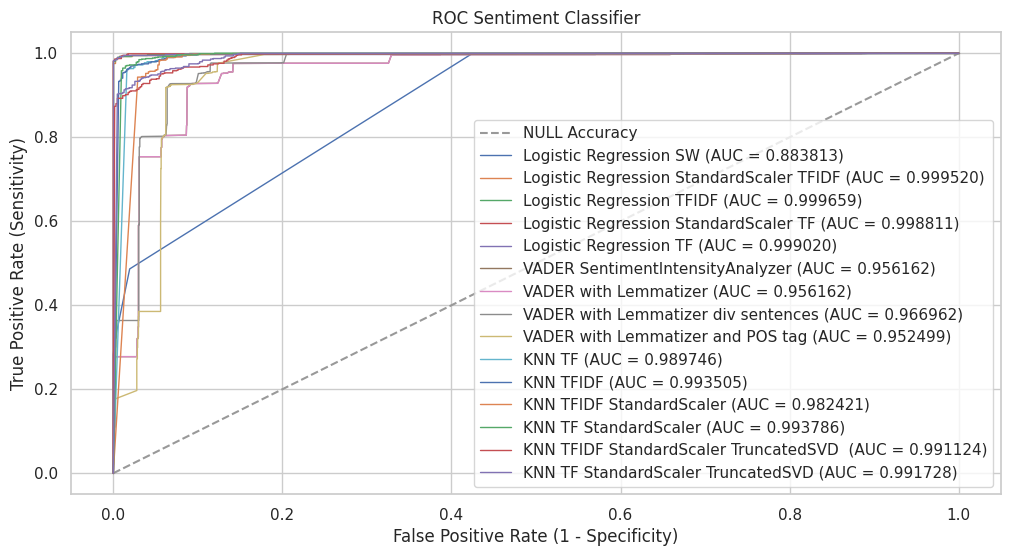

In [120]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_vader_lemmatizer, tpr_vader_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_vader_lemmatizer)
plt.plot(fpr_vader_lemma_div, tpr_vader_lemma_div, lw=1, label='VADER with Lemmatizer div sentences (AUC = %0.6f)' % roc_auc_vader_lemma_div)
plt.plot(fpr_vader_lemma2, tpr_vader_lemma2, lw=1, label='VADER with Lemmatizer and POS tag (AUC = %0.6f)' % roc_auc_vader_lemma2)
plt.plot(fpr_knn_tf, tpr_knn_tf, lw=1, label='KNN TF (AUC = %0.6f)' % roc_auc_knn_tf)
plt.plot(fpr_knn_tfidf, tpr_knn_tfidf, lw=1, label='KNN TFIDF (AUC = %0.6f)' % roc_auc_knn_tfidf)
plt.plot(fpr_knn_ss_tfidf, tpr_knn_ss_tfidf, lw=1, label='KNN TFIDF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tfidf)
plt.plot(fpr_knn_ss_tf, tpr_knn_ss_tf, lw=1, label='KNN TF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tf)
plt.plot(fpr_knn_ss_tsvd_tfidf, tpr_knn_ss_tsvd_tfidf, lw=1, label='KNN TFIDF StandardScaler TruncatedSVD  (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tfidf)
plt.plot(fpr_knn_ss_tsvd_tf, tpr_knn_ss_tsvd_tf, lw=1, label='KNN TF StandardScaler TruncatedSVD (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tf)
# plt.plot(fpr_knn_ss_pca_tf, tpr_knn_ss_pca_tf, lw=1, label='KNN TF StandardScaler PCA (AUC = %0.6f)' % roc_auc_knn_ss_pca_tf)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

# **Decision Tree Classifier**

In [121]:
# Setup the pipeline with a DecisionTreeClassifier
pipeline = make_pipeline(
    TfidfVectorizer(),
    DecisionTreeClassifier(random_state=42)
    )

param_grid = {
    # 'tfidfvectorizer__max_features': [1000, 2000, 3000],  # Limit features to control overfitting
    # 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],  # Include bigrams
    'decisiontreeclassifier__max_depth': [None, 10, 20, 30, 40, 50],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # Evaluation metric to optimize
    verbose=1  # For detailed output
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_model_decisiontree = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 20, 'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__min_samples_split': 10}


In [122]:
# Make predictions using the best model
y_pred_decisiontree = best_model_decisiontree.predict(X_test)
y_pred_prob_decisiontree = best_model_decisiontree.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr_decisiontree, tpr_decisiontree, thresholds = metrics.roc_curve(y_test, y_pred_prob_decisiontree)
roc_auc_decisiontree = metrics.auc(fpr_decisiontree, tpr_decisiontree)

print("ROC AUC for the best Decision Tree model:", roc_auc_decisiontree)

ROC AUC for the best Decision Tree model: 0.9932411172427147


In [123]:
add_model_metrics('DecisionTree', y_test, y_pred_decisiontree, y_pred_prob_decisiontree, "selection")

In [124]:
# Saving the best model obtained from grid search
with open('models/DecisionTree.pkl', 'wb') as f:
    pickle.dump(best_model_decisiontree, f)

In [125]:
pipeline = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(random_state=42)
    )

param_grid = {
    'randomforestclassifier__n_estimators': [10, 50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30, 40],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='roc_auc',  # This can be changed to 'roc_auc' or other relevant metrics
    verbose=1  # For detailed output
)

# Assuming X_train_tf and y_train_tf are defined and prepared
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_model_randomforest = grid_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 200}


In [126]:
# Use the best model to make predictions
y_pred_randomforest = best_model_randomforest.predict(X_test)
y_pred_prob_randomforest = best_model_randomforest.predict_proba(X_test)[:, 1]

fpr_randomforest, tpr_randomforest, thresholds = metrics.roc_curve(y_test, y_pred_prob_randomforest)
roc_auc_randomforest = metrics.auc(fpr_randomforest, tpr_randomforest)

print("ROC AUC for the best Random Forest model with TF features:", roc_auc_randomforest)

ROC AUC for the best Random Forest model with TF features: 0.9993263303966179


In [127]:
add_model_metrics('RandomForest', y_test, y_pred_randomforest, y_pred_prob_randomforest, "selection")

In [128]:
# Save tokenizer
with open('models/RandomForest.pkl', 'wb') as handle:
    pickle.dump(best_model_randomforest, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [129]:
#Choose the best DecisionTree model
select_best_model()

Model name:  log_sw -> SCORE:  0.5856558172549684
Model name:  logreg_standscal_tfidf -> SCORE:  0.6634693039229053
Model name:  logreg_tfidf -> SCORE:  0.6635002308707652
Model name:  logreg_standardscaler_tf -> SCORE:  0.6621872876041112
Model name:  logreg_tf -> SCORE:  0.6630818300147374
Model name:  VADER -> SCORE:  0.625226848375504
Model name:  VADER_Lemma -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma_Div -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma2 -> SCORE:  0.6272431514493263
Model name:  KNN_tf -> SCORE:  0.6502105641236328
Model name:  KNN_tfidf -> SCORE:  0.652313120115965
Model name:  KNN_standardscaler_tfidf -> SCORE:  0.6448258014361351
Model name:  KNN_standardscaler_tf -> SCORE:  0.649226854244281
Model name:  KNN_standardscaler_tsvd_tfidf -> SCORE:  0.6422598885815891
Model name:  KNN_standardscaler_tsvd_tf -> SCORE:  0.6429920423879605
Model name:  DecisionTree -> SCORE:  0.6581383669363562
Model name:  RandomForest -> SCORE:  0.6611975205129303


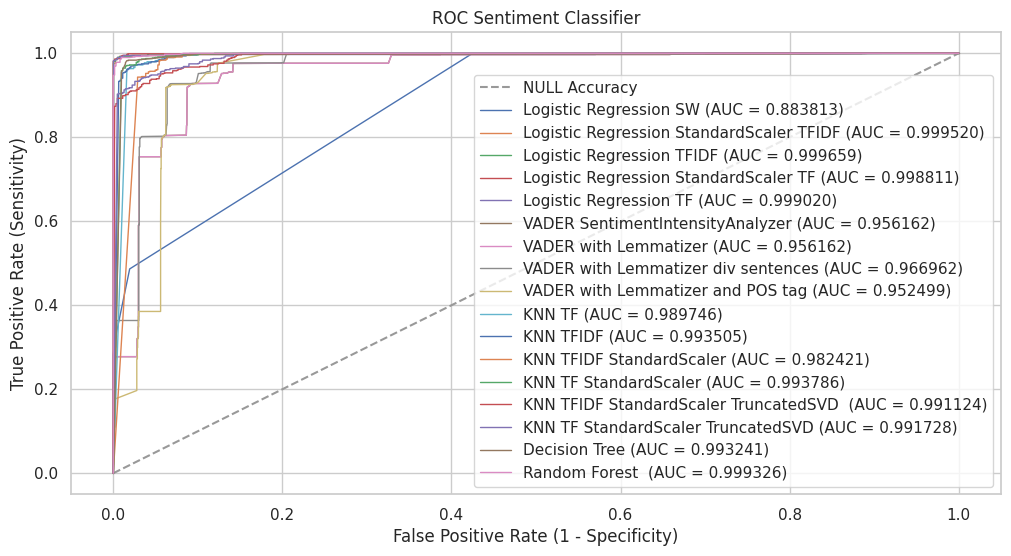

In [130]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_vader_lemmatizer, tpr_vader_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_vader_lemmatizer)
plt.plot(fpr_vader_lemma_div, tpr_vader_lemma_div, lw=1, label='VADER with Lemmatizer div sentences (AUC = %0.6f)' % roc_auc_vader_lemma_div)
plt.plot(fpr_vader_lemma2, tpr_vader_lemma2, lw=1, label='VADER with Lemmatizer and POS tag (AUC = %0.6f)' % roc_auc_vader_lemma2)
plt.plot(fpr_knn_tf, tpr_knn_tf, lw=1, label='KNN TF (AUC = %0.6f)' % roc_auc_knn_tf)
plt.plot(fpr_knn_tfidf, tpr_knn_tfidf, lw=1, label='KNN TFIDF (AUC = %0.6f)' % roc_auc_knn_tfidf)
plt.plot(fpr_knn_ss_tfidf, tpr_knn_ss_tfidf, lw=1, label='KNN TFIDF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tfidf)
plt.plot(fpr_knn_ss_tf, tpr_knn_ss_tf, lw=1, label='KNN TF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tf)
plt.plot(fpr_knn_ss_tsvd_tfidf, tpr_knn_ss_tsvd_tfidf, lw=1, label='KNN TFIDF StandardScaler TruncatedSVD  (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tfidf)
plt.plot(fpr_knn_ss_tsvd_tf, tpr_knn_ss_tsvd_tf, lw=1, label='KNN TF StandardScaler TruncatedSVD (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tf)
plt.plot(fpr_decisiontree, tpr_decisiontree, lw=1, label='Decision Tree (AUC = %0.6f)' % roc_auc_decisiontree)
plt.plot(fpr_randomforest, tpr_randomforest, lw=1, label='Random Forest  (AUC = %0.6f)' % roc_auc_randomforest)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

# **TRAIN - VALIDATION set split**

In [131]:
# Preprocessing parameters
vocab_size = 20000  # Max number of words in dict
max_length = 100    # Max length sequence

# Tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data_df.comment)

# Convert txt to sequence
X = tokenizer.texts_to_sequences(train_data_df.comment)
X = pad_sequences(X, maxlen=max_length)

y = train_data_df.sentiment.values

# Train, validation set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# **CNN - Convolutional Neural Network**

In [132]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined here based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='grid_search_cnn'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_cnn = tuner.get_best_models(num_models=1)[0]
best_model_cnn.evaluate(X_test, y_test)

Trial 3 Complete [00h 00m 12s]
val_loss: 0.24171818792819977

Best val_loss So Far: 0.022269630804657936
Total elapsed time: 00h 00m 46s
74/74 [==============================] - 1s 4ms/step - loss: 0.0223 - auc: 0.9993


[0.022269630804657936, 0.9993487000465393]

In [133]:
y_pred_prob_cnn = best_model_cnn.predict(X_test).flatten()  # Get the probabilities
y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_cnn = metrics.roc_auc_score(y_test, y_pred_prob_cnn)
fpr_cnn, tpr_cnn, thresholds = metrics.roc_curve(y_test, y_pred_prob_cnn)
print("ROC AUC Score:", roc_auc_cnn)

74/74 [==============================] - 0s 4ms/step
ROC AUC Score: 0.9996888849097991


In [134]:
add_model_metrics('CNN', y_test, y_pred_cnn, y_pred_prob_cnn, "selection")

In [135]:
# Save the entire model as a SavedModel.
best_model_cnn.save('models/CNN')

In [136]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())

    # Adding L1 and L2 regularization
    l1_value = hp.Choice('l1_reg', values=[1e-2, 1e-3, 1e-4])
    l2_value = hp.Choice('l2_reg', values=[1e-2, 1e-3, 1e-4])
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(l1=l1_value, l2=l2_value)))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='grid_search_cnn'
)

# Make sure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_cnn_reg = tuner.get_best_models(num_models=1)[0]
results_cnn_reg = best_model_cnn_reg.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_cnn_reg)

y_pred_prob_cnn_reg = best_model_cnn_reg.predict(X_test).flatten()  # Get the probabilities
y_pred_cnn_reg = (y_pred_prob_cnn_reg > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_cnn_reg = metrics.roc_auc_score(y_test, y_pred_prob_cnn_reg)
fpr_cnn_reg, tpr_cnn_reg, thresholds = metrics.roc_curve(y_test, y_pred_prob_cnn_reg)
print("ROC AUC Score:", roc_auc_cnn_reg)

Trial 3 Complete [00h 00m 12s]
val_loss: 0.862674355506897

Best val_loss So Far: 0.029206810519099236
Total elapsed time: 00h 00m 35s
74/74 [==============================] - 1s 4ms/step - loss: 0.0292 - auc: 0.9995
Test Loss, Test AUC: [0.029206810519099236, 0.9995299577713013]
74/74 [==============================] - 0s 2ms/step
ROC AUC Score: 0.999669486846621


In [137]:
add_model_metrics('CNN_reg', y_test, y_pred_cnn_reg, y_pred_prob_cnn_reg, "selection")

In [138]:
# Save the entire model as a SavedModel.
best_model_cnn_reg.save('models/CNN_reg')

In [139]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_conv', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout after convolutional layer
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_dense', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout after Dense layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='grid_search_cnn'
)

tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_cnn_dropout = tuner.get_best_models(num_models=1)[0]
results_cnn_dropout = best_model_cnn_dropout.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_cnn_dropout)

y_pred_prob_cnn_dropout = best_model_cnn_dropout.predict(X_test).flatten()
y_pred_cnn_dropout = (y_pred_prob_cnn_dropout > 0.5).astype(int)

roc_auc_cnn_dropout = metrics.roc_auc_score(y_test, y_pred_prob_cnn_dropout)
fpr_cnn_cnn_dropout, tpr_cnn_dropout, thresholds = metrics.roc_curve(y_test, y_pred_prob_cnn_dropout)
print("ROC AUC Score:", roc_auc_cnn_dropout)


Trial 3 Complete [00h 00m 17s]
val_loss: 0.1705678105354309

Best val_loss So Far: 0.017820507287979126
Total elapsed time: 00h 00m 53s
74/74 [==============================] - 1s 3ms/step - loss: 0.0178 - auc: 0.9998
Test Loss, Test AUC: [0.017820507287979126, 0.999800443649292]
74/74 [==============================] - 0s 2ms/step
ROC AUC Score: 0.9998052732888669


In [140]:
add_model_metrics('CNN_dropout', y_test, y_pred_cnn_dropout, y_pred_prob_cnn_dropout, "selection")

In [141]:
# Save the entire model as a SavedModel.
best_model_cnn_dropout.save('models/CNN_dropout')

In [142]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_conv', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout after convolution
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Choice('l1_reg', values=[1e-2, 1e-3, 1e-4]),
            l2=hp.Choice('l2_reg', values=[1e-2, 1e-3, 1e-4]))))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_dense', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout after dense layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='grid_search_cnn'
)

tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_cnn_reg_dropout = tuner.get_best_models(num_models=1)[0]
results_cnn_reg_dropout = best_model_cnn_reg_dropout.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_cnn_reg_dropout)

y_pred_prob_cnn_reg_dropout = best_model_cnn_reg_dropout.predict(X_test).flatten()
y_pred_cnn_reg_dropout = (y_pred_prob_cnn_reg_dropout > 0.5).astype(int)

roc_auc_cnn_reg_dropout = metrics.roc_auc_score(y_test, y_pred_prob_cnn_reg_dropout)
fpr_cnn_cnn_reg_dropout, tpr_cnn_reg_dropout, thresholds = metrics.roc_curve(y_test, y_pred_prob_cnn_reg_dropout)
print("ROC AUC Score:", roc_auc_cnn_reg_dropout)

Trial 3 Complete [00h 00m 12s]
val_loss: 0.9340714812278748

Best val_loss So Far: 0.02623239904642105
Total elapsed time: 00h 00m 56s
74/74 [==============================] - 1s 3ms/step - loss: 0.0262 - auc: 0.9995
Test Loss, Test AUC: [0.02623239904642105, 0.9994900226593018]
74/74 [==============================] - 0s 3ms/step
ROC AUC Score: 0.9994986346747841


In [143]:
add_model_metrics('CNN_reg_dropout', y_test, y_pred_cnn_reg_dropout, y_pred_prob_cnn_reg_dropout, "selection")

In [144]:
# Save the entire model as a SavedModel.
best_model_cnn_reg_dropout.save('models/CNN_reg_dropout')

In [145]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    # Embedding layer that turns positive integers (indexes) into dense vectors
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    # Convolutional layer that will learn local patterns
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))
    # Gaussian Noise added as a regularization method
    model.add(keras.layers.GaussianNoise(hp.Float('noise_conv', min_value=0.0, max_value=0.5, step=0.1)))
    # Global Max Pooling layer to reduce dimensionality and extract important features
    model.add(keras.layers.GlobalMaxPooling1D())
    # Dense layer to perform classification
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu'))
    # Another Gaussian Noise layer after Dense layer for additional regularization
    model.add(keras.layers.GaussianNoise(hp.Float('noise_dense', min_value=0.0, max_value=0.5, step=0.1)))
    # Output layer with sigmoid activation for binary classification
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compiling the model with Adam optimizer and binary crossentropy as the loss function
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Setting up a GridSearch tuner from Keras Tuner to find the best hyperparameters
tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='grid_search_cnn_rand'
)

# Running the hyperparameter tuning process
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Fetching the best model and evaluating it on the test set
best_model_cnn_reg_noise = tuner.get_best_models(num_models=1)[0]
results_cnn_reg_noise = best_model_cnn_reg_noise.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_cnn_reg_noise)

Trial 3 Complete [00h 00m 22s]
val_loss: 0.31704649329185486

Best val_loss So Far: 0.01752532832324505
Total elapsed time: 00h 00m 58s
74/74 [==============================] - 1s 4ms/step - loss: 0.0175 - auc: 0.9995
Test Loss, Test AUC: [0.01752532832324505, 0.9994956254959106]


In [146]:
# Making predictions with the best model
y_pred_prob_cnn_reg_noise = best_model_cnn_reg_noise.predict(X_test).flatten()  # Get probabilities
y_pred_cnn_reg_noise = (y_pred_prob_cnn_reg_noise > 0.5).astype(int)  # Convert probabilities to binary class labels

# Calculating the ROC AUC score to evaluate the classifier's performance
roc_auc_cnn_reg_noise = metrics.roc_auc_score(y_test, y_pred_prob_cnn_reg_noise)
fpr_cnn_reg_noise, tpr_cnn_reg_noise, thresholds = metrics.roc_curve(y_test, y_pred_prob_cnn_reg_noise)
print("ROC AUC Score:", roc_auc_cnn_reg_noise)

74/74 [==============================] - 0s 4ms/step
ROC AUC Score: 0.9997112672903891


In [147]:
add_model_metrics('CNN_reg_noise', y_test, y_pred_cnn_reg_noise, y_pred_prob_cnn_reg_noise, "selection")

In [148]:
# Save the entire model as a SavedModel.
best_model_cnn_reg_noise.save('models/CNN_reg_noise')

In [149]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    # Embedding layer that turns positive integers (indexes) into dense vectors
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    # Convolutional layer that will learn local patterns
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))
    # Global Max Pooling layer to reduce dimensionality and extract important features
    model.add(keras.layers.GlobalMaxPooling1D())
    # Dense layer to perform classification
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu'))
    # Output layer with sigmoid activation for binary classification
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compiling the model with Adam optimizer and binary crossentropy as the loss function
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Setting up a GridSearch tuner from Keras Tuner to find the best hyperparameters
tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='grid_search_cnn_no_reg'
)

# Running the hyperparameter tuning process
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Fetching the best model and evaluating it on the test set
best_model_cnn_noise = tuner.get_best_models(num_models=1)[0]
results_cnn_noise = best_model_cnn_noise.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_cnn_noise)

Trial 3 Complete [00h 00m 11s]
val_loss: 0.18216459453105927

Best val_loss So Far: 0.020177211612462997
Total elapsed time: 00h 00m 34s
74/74 [==============================] - 1s 5ms/step - loss: 0.0202 - auc: 0.9995
Test Loss, Test AUC: [0.020177211612462997, 0.9994673132896423]


In [150]:
# Making predictions with the best model
y_pred_prob_cnn_noise = best_model_cnn_noise.predict(X_test).flatten()  # Get probabilities
y_pred_cnn_noise = (y_pred_prob_cnn_noise > 0.5).astype(int)  # Convert probabilities to binary class labels

# Calculating the ROC AUC score to evaluate the classifier's performance
roc_auc_cnn_noise = metrics.roc_auc_score(y_test, y_pred_prob_cnn_noise)
fpr_cnn_noise, tpr_cnn_noise, thresholds = metrics.roc_curve(y_test, y_pred_prob_cnn_noise)
print("ROC AUC Score:", roc_auc_cnn_noise)

74/74 [==============================] - 0s 4ms/step
ROC AUC Score: 0.999808257606279


In [151]:
add_model_metrics('CNN_noise', y_test, y_pred_cnn_noise, y_pred_prob_cnn_noise, "selection")

In [152]:
# Save the entire model as a SavedModel.
best_model_cnn_noise.save('models/CNN_noise')

In [153]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu'))

    # Let the tuner choose between GaussianNoise and Dropout for regularization after Conv1D
    if hp.Choice('reg_conv_type', ['gaussian_noise', 'dropout']) == 'gaussian_noise':
        model.add(keras.layers.GaussianNoise(hp.Float('noise_conv', min_value=0.0, max_value=0.5, step=0.1)))
    else:
        model.add(keras.layers.Dropout(hp.Float('dropout_conv', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu'))

    # Let the tuner choose between GaussianNoise and Dropout for regularization after Dense
    if hp.Choice('reg_dense_type', ['gaussian_noise', 'dropout']) == 'gaussian_noise':
        model.add(keras.layers.GaussianNoise(hp.Float('noise_dense', min_value=0.0, max_value=0.5, step=0.1)))
    else:
        model.add(keras.layers.Dropout(hp.Float('dropout_dense', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Selecting an optimizer
    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop', 'adagrad', 'momentum'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    if optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=hp.Float('momentum', min_value=0.0, max_value=0.9))
    elif optimizer_choice == 'momentum':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=hp.Float('momentum', min_value=0.0, max_value=0.9))
    else:
        optimizer = keras.optimizers.get(optimizer_choice)(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Setup Keras Tuner
tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=10,  # Increased trials to test combinations
    overwrite=True,
    executions_per_trial=2,
    directory='my_dir',
    project_name='grid_search_reg_methods'
)

# Running the tuner
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Getting the best model
best_model_cnn_noise_dropout_optimizer = tuner.get_best_models(num_models=1)[0]
results_cnn_noise_dropout_optimizer = best_model_cnn_noise_dropout_optimizer.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_cnn_noise_dropout_optimizer)

Trial 10 Complete [00h 00m 23s]
val_loss: 0.687063455581665

Best val_loss So Far: 0.687063455581665
Total elapsed time: 00h 03m 49s
74/74 [==============================] - 1s 3ms/step - loss: 0.6843 - auc: 0.6819
Test Loss, Test AUC: [0.6843405961990356, 0.6819333434104919]


In [154]:
# Prediction and Evaluation
y_pred_prob_cnn_noise_dropout_optimizer = best_model_cnn_noise_dropout_optimizer.predict(X_test).flatten()  # Get probabilities
y_pred_cnn_noise_dropout_optimizer = (y_pred_prob_cnn_noise_dropout_optimizer > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_cnn_noise_dropout_optimizer = metrics.roc_auc_score(y_test, y_pred_prob_cnn_noise_dropout_optimizer)
fpr_cnn_noise_dropout_optimizer, tpr_cnn_noise_dropout_optimizer, thresholds = metrics.roc_curve(y_test, y_pred_prob_cnn_noise_dropout_optimizer)
print("ROC AUC Score:", roc_auc_cnn_noise_dropout_optimizer)

74/74 [==============================] - 0s 2ms/step
ROC AUC Score: 0.6903897518540072


In [155]:
add_model_metrics('CNN_noise_dropout_optimizer', y_test, y_pred_cnn_noise_dropout_optimizer,
                  y_pred_prob_cnn_noise_dropout_optimizer, "selection")

In [156]:
# Save the entire model as a SavedModel.
best_model_cnn_noise_dropout_optimizer.save('models/CNN_noise_dropout_optimizer')

In [157]:
#Choose the best CNN model
select_best_model()

Model name:  log_sw -> SCORE:  0.5856558172549684
Model name:  logreg_standscal_tfidf -> SCORE:  0.6634693039229053
Model name:  logreg_tfidf -> SCORE:  0.6635002308707652
Model name:  logreg_standardscaler_tf -> SCORE:  0.6621872876041112
Model name:  logreg_tf -> SCORE:  0.6630818300147374
Model name:  VADER -> SCORE:  0.625226848375504
Model name:  VADER_Lemma -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma_Div -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma2 -> SCORE:  0.6272431514493263
Model name:  KNN_tf -> SCORE:  0.6502105641236328
Model name:  KNN_tfidf -> SCORE:  0.652313120115965
Model name:  KNN_standardscaler_tfidf -> SCORE:  0.6448258014361351
Model name:  KNN_standardscaler_tf -> SCORE:  0.649226854244281
Model name:  KNN_standardscaler_tsvd_tfidf -> SCORE:  0.6422598885815891
Model name:  KNN_standardscaler_tsvd_tf -> SCORE:  0.6429920423879605
Model name:  DecisionTree -> SCORE:  0.6581383669363562
Model name:  RandomForest -> SCORE:  0.6611975205129303


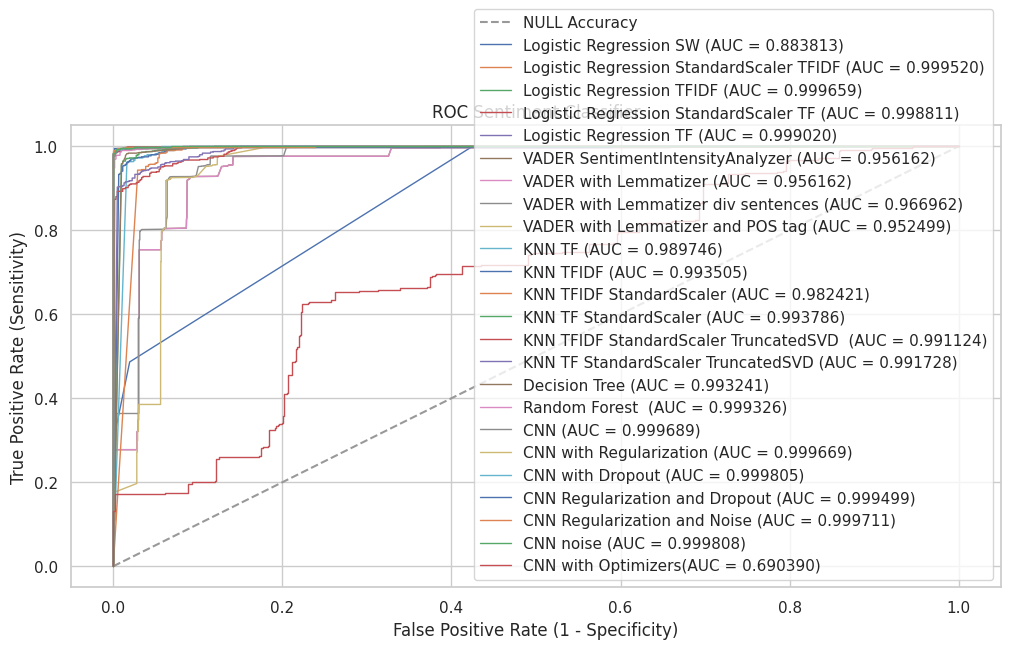

In [158]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_vader_lemmatizer, tpr_vader_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_vader_lemmatizer)
plt.plot(fpr_vader_lemma_div, tpr_vader_lemma_div, lw=1, label='VADER with Lemmatizer div sentences (AUC = %0.6f)' % roc_auc_vader_lemma_div)
plt.plot(fpr_vader_lemma2, tpr_vader_lemma2, lw=1, label='VADER with Lemmatizer and POS tag (AUC = %0.6f)' % roc_auc_vader_lemma2)
plt.plot(fpr_knn_tf, tpr_knn_tf, lw=1, label='KNN TF (AUC = %0.6f)' % roc_auc_knn_tf)
plt.plot(fpr_knn_tfidf, tpr_knn_tfidf, lw=1, label='KNN TFIDF (AUC = %0.6f)' % roc_auc_knn_tfidf)
plt.plot(fpr_knn_ss_tfidf, tpr_knn_ss_tfidf, lw=1, label='KNN TFIDF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tfidf)
plt.plot(fpr_knn_ss_tf, tpr_knn_ss_tf, lw=1, label='KNN TF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tf)
plt.plot(fpr_knn_ss_tsvd_tfidf, tpr_knn_ss_tsvd_tfidf, lw=1, label='KNN TFIDF StandardScaler TruncatedSVD  (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tfidf)
plt.plot(fpr_knn_ss_tsvd_tf, tpr_knn_ss_tsvd_tf, lw=1, label='KNN TF StandardScaler TruncatedSVD (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tf)
plt.plot(fpr_decisiontree, tpr_decisiontree, lw=1, label='Decision Tree (AUC = %0.6f)' % roc_auc_decisiontree)
plt.plot(fpr_randomforest, tpr_randomforest, lw=1, label='Random Forest  (AUC = %0.6f)' % roc_auc_randomforest)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='CNN (AUC = %0.6f)' % roc_auc_cnn)
plt.plot(fpr_cnn_reg, tpr_cnn_reg, lw=1, label='CNN with Regularization (AUC = %0.6f)' % roc_auc_cnn_reg)
plt.plot(fpr_cnn_cnn_dropout, tpr_cnn_dropout, lw=1, label='CNN with Dropout (AUC = %0.6f)' % roc_auc_cnn_dropout)
plt.plot(fpr_cnn_cnn_reg_dropout, tpr_cnn_reg_dropout, lw=1, label='CNN Regularization and Dropout (AUC = %0.6f)' % roc_auc_cnn_reg_dropout)
plt.plot(fpr_cnn_reg_noise, tpr_cnn_reg_noise, lw=1, label='CNN Regularization and Noise (AUC = %0.6f)' % roc_auc_cnn_reg_noise)
plt.plot(fpr_cnn_noise, tpr_cnn_noise, lw=1, label='CNN noise (AUC = %0.6f)' % roc_auc_cnn_noise)
plt.plot(fpr_cnn_noise_dropout_optimizer, tpr_cnn_noise_dropout_optimizer, lw=1, label='CNN with Optimizers(AUC = %0.6f)' % roc_auc_cnn_noise_dropout_optimizer)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

# **RNN - Recurrent Neural Network**

In [159]:
#Recurrent Neural Network (RNN)

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_rnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_rnn = model_rnn.predict(X_test).flatten()
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)
fpr_rnn, tpr_rnn, thresholds = metrics.roc_curve(y_test, y_pred_prob_rnn)
roc_auc_rnn = metrics.auc(fpr_rnn, tpr_rnn)

print(f"ROC AUC: {roc_auc_rnn}")

Epoch 1/5
149/149 [==============================] - 7s 40ms/step - loss: 0.2497 - auc: 0.9725 - val_loss: 0.0934 - val_auc: 0.9958
Epoch 2/5
149/149 [==============================] - 5s 32ms/step - loss: 0.0373 - auc: 0.9994 - val_loss: 0.0719 - val_auc: 0.9972
Epoch 3/5
149/149 [==============================] - 5s 31ms/step - loss: 0.0119 - auc: 0.9999 - val_loss: 0.0720 - val_auc: 0.9972
Epoch 4/5
149/149 [==============================] - 6s 39ms/step - loss: 0.0053 - auc: 1.0000 - val_loss: 0.0622 - val_auc: 0.9979
Epoch 5/5
74/74 [==============================] - 1s 8ms/step
ROC AUC: 0.9978885954310102


In [160]:
add_model_metrics('RNN', y_test, y_pred_rnn, y_pred_prob_rnn, "selection")

In [161]:
# Save the entire model as a SavedModel.
model_rnn.save('models/RNN')

In [162]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a LSTM layer
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # set to True if stacking LSTM layers, else False
        dropout=hp.Float('lstm_dropout', min_value=0.0, max_value=0.5, step=0.1),  # dropout for input
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1)  # dropout for recurrent state
    ))

    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout after dense layer

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_rnn_dropout = tuner.get_best_models(num_models=1)[0]
results_rnn_dropout = best_model_rnn_dropout.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_rnn_dropout)

y_pred_prob_rnn_dropout = best_model_rnn_dropout.predict(X_test).flatten()  # Get the probabilities
y_pred_rnn_dropout = (y_pred_prob_rnn_dropout > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_rnn_dropout = metrics.roc_auc_score(y_test, y_pred_prob_rnn_dropout)
fpr_rnn_dropout, tpr_rnn_dropout, thresholds = metrics.roc_curve(y_test, y_pred_prob_rnn_dropout)
print("ROC AUC Score:", roc_auc_rnn_dropout)


Trial 3 Complete [00h 00m 44s]
val_loss: 0.19560368359088898

Best val_loss So Far: 0.04586857184767723
Total elapsed time: 00h 02m 13s
74/74 [==============================] - 2s 14ms/step - loss: 0.0459 - auc: 0.9982
Test Loss, Test AUC: [0.04586857184767723, 0.9982362985610962]
74/74 [==============================] - 2s 15ms/step
ROC AUC Score: 0.9985443991822971


In [163]:
add_model_metrics('RNN_dropout', y_test, y_pred_rnn_dropout, y_pred_prob_rnn_dropout, "selection")

In [164]:
# Save the entire model as a SavedModel.
best_model_rnn_dropout.save('models/RNN_dropout')

In [165]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a LSTM layer with dropout
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # set to True if stacking LSTM layers, else False
        dropout=hp.Float('lstm_dropout', min_value=0.0, max_value=0.5, step=0.1),  # dropout for input
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1)  # dropout for recurrent state
    ))

    # Adding a Dense layer with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    model.add(keras.layers.Dropout(rate=hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout after dense layer

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_rnn_reg_dropout = tuner.get_best_models(num_models=1)[0]
results_rnn_reg_dropout = best_model_rnn_reg_dropout.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_rnn_reg_dropout)

y_pred_prob_rnn_reg_dropout = best_model_rnn_reg_dropout.predict(X_test).flatten()  # Get the probabilities
y_pred_rnn_reg_dropout = (y_pred_prob_rnn_reg_dropout > 0.5).astype(int)  # Convert probabilities to binary class labels

fpr_rnn_reg_dropout, tpr_rnn_reg_dropout, thresholds = metrics.roc_curve(y_test, y_pred_prob_rnn_reg_dropout)
roc_auc_rnn_reg_dropout = metrics.roc_auc_score(y_test, y_pred_prob_rnn_reg_dropout)
print("ROC AUC Score:", roc_auc_rnn_reg_dropout)


Trial 3 Complete [00h 00m 44s]
val_loss: 0.14830121397972107

Best val_loss So Far: 0.04881717637181282
Total elapsed time: 00h 02m 13s
74/74 [==============================] - 2s 11ms/step - loss: 0.0488 - auc: 0.9985
Test Loss, Test AUC: [0.04881717637181282, 0.9985030889511108]
74/74 [==============================] - 1s 10ms/step
ROC AUC Score: 0.9989554889058


In [166]:
add_model_metrics('RNN_reg_dropout', y_test, y_pred_rnn_reg_dropout, y_pred_prob_rnn_reg_dropout, "selection")

In [167]:
# Save the entire model as a SavedModel.
best_model_rnn_reg_dropout.save('models/RNN_reg_dropout')

In [168]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a LSTM layer
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False  # set to True if stacking LSTM layers, else False
    ))

    # Adding a Dense layer with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_rnn_reg = tuner.get_best_models(num_models=1)[0]
results_rnn_reg = best_model_rnn_reg.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_rnn_reg)

y_pred_prob_rnn_reg = best_model_rnn_reg.predict(X_test).flatten()  # Get the probabilities
y_pred_rnn_reg = (y_pred_prob_rnn_reg > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_rnn_reg = metrics.roc_auc_score(y_test, y_pred_prob_rnn_reg)
fpr_rnn_reg, tpr_rnn_reg, thresholds = metrics.roc_curve(y_test, y_pred_prob_rnn_reg)
print("ROC AUC Score:", roc_auc_rnn_reg)

Trial 3 Complete [00h 00m 44s]
val_loss: 0.23614418506622314

Best val_loss So Far: 0.04325433820486069
Total elapsed time: 00h 02m 53s
74/74 [==============================] - 2s 14ms/step - loss: 0.0433 - auc: 0.9963
Test Loss, Test AUC: [0.04325433820486069, 0.9962587952613831]
74/74 [==============================] - 2s 14ms/step
ROC AUC Score: 0.999385230613128


In [169]:
add_model_metrics('RNN_reg', y_test, y_pred_rnn_reg, y_pred_prob_rnn_reg, "selection")

In [170]:
# Save the entire model as a SavedModel.
best_model_rnn_reg.save('models/RNN_reg')

In [171]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a simple LSTM layer
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False  # Set to True if stacking LSTM layers, else False
    ))

    # Adding a Dense layer
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=10, max_value=100, step=10),
        activation='relu'
    ))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_rnn_gs = tuner.get_best_models(num_models=1)[0]
results_rnn_gs = best_model_rnn_gs.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_rnn_gs)

Trial 3 Complete [00h 00m 43s]
val_loss: 0.10484840720891953

Best val_loss So Far: 0.050337910652160645
Total elapsed time: 00h 02m 11s
74/74 [==============================] - 2s 14ms/step - loss: 0.0503 - auc: 0.9981
Test Loss, Test AUC: [0.050337910652160645, 0.9981101751327515]


In [172]:
y_pred_prob_rnn_gs = best_model_rnn_gs.predict(X_test).flatten()  # Get the probabilities
y_pred_rnn_gs = (y_pred_prob_rnn_gs > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_rnn_gs = metrics.roc_auc_score(y_test, y_pred_prob_rnn_gs)
fpr_rnn_gs, tpr_rnn_gs, thresholds = metrics.roc_curve(y_test, y_pred_prob_rnn_gs)
print("ROC AUC Score:", roc_auc_rnn_gs)

74/74 [==============================] - 2s 14ms/step
ROC AUC Score: 0.999095005744811


In [173]:
add_model_metrics('RNN_gs', y_test, y_pred_rnn_gs, y_pred_prob_rnn_gs, "selection")

In [174]:
# Save the entire model as a SavedModel.
best_model_rnn_gs.save('models/RNN_gs')

In [175]:
def build_model_rnn_noise_dropout_optimizer(hp, vocab_size, max_length):
    model = keras.Sequential(name="model_rnn_noise_dropout_optimizer")
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length, name="embedding_rnn_noise_dropout_optimizer"))

    # Adding a LSTM layer with dynamic unit selection
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units_rnn_noise_dropout_optimizer', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking LSTM layers, else False
        name="lstm_rnn_noise_dropout_optimizer"
    ))

    # Conditional regularization choice
    reg_type = hp.Choice('reg_type_rnn_noise_dropout_optimizer', ['gaussian_noise', 'dropout'])
    if reg_type == 'gaussian_noise':
        model.add(keras.layers.GaussianNoise(
            hp.Float('noise_level_rnn_noise_dropout_optimizer', min_value=0.0, max_value=0.5, step=0.1),
            name="gaussian_noise_rnn_noise_dropout_optimizer"
        ))
    else:
        model.add(keras.layers.Dropout(
            hp.Float('dropout_rate_rnn_noise_dropout_optimizer', min_value=0.0, max_value=0.5, step=0.1),
            name="dropout_rnn_noise_dropout_optimizer"
        ))

    # Dense layer with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units_rnn_noise_dropout_optimizer', min_value=10, max_value=100, step=10),
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg_rnn_noise_dropout_optimizer', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg_rnn_noise_dropout_optimizer', min_value=1e-5, max_value=1e-2, sampling='log')
        ),
        name="dense_rnn_noise_dropout_optimizer"
    ))

    model.add(keras.layers.Dense(1, activation='sigmoid', name="output_rnn_noise_dropout_optimizer"))

    # Selecting an optimizer
    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop', 'adagrad', 'momentum'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    if optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=hp.Float('momentum', min_value=0.0, max_value=0.9))
    elif optimizer_choice == 'momentum':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=hp.Float('momentum', min_value=0.0, max_value=0.9))
    else:
        optimizer = keras.optimizers.get(optimizer_choice)(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

vocab_size = 10000  # Example value
max_length = 100    # Example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model_rnn_noise_dropout_optimizer(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search_with_reg_optimizer'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_rnn_noise_dropout_optimizer = tuner.get_best_models(num_models=1)[0]
results_rnn_noise_dropout_optimizer = best_model_rnn_noise_dropout_optimizer.evaluate(X_test, y_test)
print("Test Loss, Test AUC_rnn_noise_dropout_optimizer:", results_rnn_noise_dropout_optimizer)

Trial 3 Complete [00h 00m 41s]
val_loss: 0.6927559971809387

Best val_loss So Far: 0.692200779914856
Total elapsed time: 00h 02m 09s
74/74 [==============================] - 2s 10ms/step - loss: 0.6922 - auc: 0.5841
Test Loss, Test AUC_rnn_noise_dropout_optimizer: [0.692200779914856, 0.5840630531311035]


In [176]:
def build_model_rnn_noise_dropout_optimizer(hp, vocab_size, max_length):
    model = keras.Sequential(name="model_rnn_noise_dropout_optimizer")
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length, name="embedding_rnn_noise_dropout_optimizer"))

    # Adding a LSTM layer with dynamic unit selection
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units_rnn_noise_dropout_optimizer', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking LSTM layers, else False
        name="lstm_rnn_noise_dropout_optimizer"
    ))

    # Conditional regularization choice
    reg_type = hp.Choice('reg_type_rnn_noise_dropout_optimizer', ['gaussian_noise', 'dropout'])
    if reg_type == 'gaussian_noise':
        model.add(keras.layers.GaussianNoise(
            hp.Float('noise_level_rnn_noise_dropout_optimizer', min_value=0.0, max_value=0.5, step=0.1),
            name="gaussian_noise_rnn_noise_dropout_optimizer"
        ))
    else:
        model.add(keras.layers.Dropout(
            hp.Float('dropout_rate_rnn_noise_dropout_optimizer', min_value=0.0, max_value=0.5, step=0.1),
            name="dropout_rnn_noise_dropout_optimizer"
        ))

    # Dense layer with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units_rnn_noise_dropout_optimizer', min_value=10, max_value=100, step=10),
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg_rnn_noise_dropout_optimizer', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg_rnn_noise_dropout_optimizer', min_value=1e-5, max_value=1e-2, sampling='log')
        ),
        name="dense_rnn_noise_dropout_optimizer"
    ))

    model.add(keras.layers.Dense(1, activation='sigmoid', name="output_rnn_noise_dropout_optimizer"))

    # Optimizer selection
    optimizer_choice = hp.Choice('optimizer_rnn_noise_dropout_optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    learning_rate = hp.Float('learning_rate_rnn_noise_dropout_optimizer', min_value=1e-4, max_value=1e-2, sampling='log')
    if optimizer_choice == 'sgd':
      optimizer = keras.optimizers.SGD(learning_rate=learning_rate, name="sgd_rnn_noise_dropout_optimizer")
    else:
      # Properly instantiate the optimizer with the specified learning rate
      optimizer = keras.optimizers.get({
          'class_name': optimizer_choice,
          'config': {'learning_rate': learning_rate}
          })

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

vocab_size = 10000  # Example value
max_length = 100    # Example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model_rnn_noise_dropout_optimizer(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search_with_reg_optimizer'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_rnn_noise_dropout_optimizer = tuner.get_best_models(num_models=1)[0]
results_rnn_noise_dropout_optimizer = best_model_rnn_noise_dropout_optimizer.evaluate(X_test, y_test)
print("Test Loss, Test AUC_rnn_noise_dropout_optimizer:", results_rnn_noise_dropout_optimizer)

Trial 3 Complete [00h 00m 45s]
val_loss: 0.04382828623056412

Best val_loss So Far: 0.04382828623056412
Total elapsed time: 00h 02m 12s
74/74 [==============================] - 2s 11ms/step - loss: 0.0438 - auc: 0.9974
Test Loss, Test AUC_rnn_noise_dropout_optimizer: [0.04382828623056412, 0.9974184632301331]


In [177]:
y_pred_prob_rnn_noise_dropout_optimizer = best_model_rnn_noise_dropout_optimizer.predict(X_test).flatten()  # Get the probabilities
y_pred_rnn_noise_dropout_optimizer = (y_pred_prob_rnn_noise_dropout_optimizer > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_rnn_noise_dropout_optimizer = metrics.roc_auc_score(y_test, y_pred_prob_rnn_noise_dropout_optimizer)
fpr_rnn_noise_dropout_optimizer, tpr_rnn_noise_dropout_optimizer, thresholds = metrics.roc_curve(y_test, y_pred_prob_rnn_noise_dropout_optimizer)
print("ROC AUC Score_rnn_noise_dropout_optimizer:", roc_auc_rnn_noise_dropout_optimizer)

74/74 [==============================] - 1s 10ms/step
ROC AUC Score_rnn_noise_dropout_optimizer: 0.9981407702523241


In [178]:
add_model_metrics('RNN_noise_dropout_optimizer', y_test,
                  y_pred_rnn_noise_dropout_optimizer, y_pred_prob_rnn_noise_dropout_optimizer, "selection")

In [179]:
# Save the entire model as a SavedModel.
best_model_rnn_noise_dropout_optimizer.save('models/RNN_noise_dropout_optimizer')

In [180]:
#Choose the best RNN model
select_best_model()

Model name:  log_sw -> SCORE:  0.5856558172549684
Model name:  logreg_standscal_tfidf -> SCORE:  0.6634693039229053
Model name:  logreg_tfidf -> SCORE:  0.6635002308707652
Model name:  logreg_standardscaler_tf -> SCORE:  0.6621872876041112
Model name:  logreg_tf -> SCORE:  0.6630818300147374
Model name:  VADER -> SCORE:  0.625226848375504
Model name:  VADER_Lemma -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma_Div -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma2 -> SCORE:  0.6272431514493263
Model name:  KNN_tf -> SCORE:  0.6502105641236328
Model name:  KNN_tfidf -> SCORE:  0.652313120115965
Model name:  KNN_standardscaler_tfidf -> SCORE:  0.6448258014361351
Model name:  KNN_standardscaler_tf -> SCORE:  0.649226854244281
Model name:  KNN_standardscaler_tsvd_tfidf -> SCORE:  0.6422598885815891
Model name:  KNN_standardscaler_tsvd_tf -> SCORE:  0.6429920423879605
Model name:  DecisionTree -> SCORE:  0.6581383669363562
Model name:  RandomForest -> SCORE:  0.6611975205129303


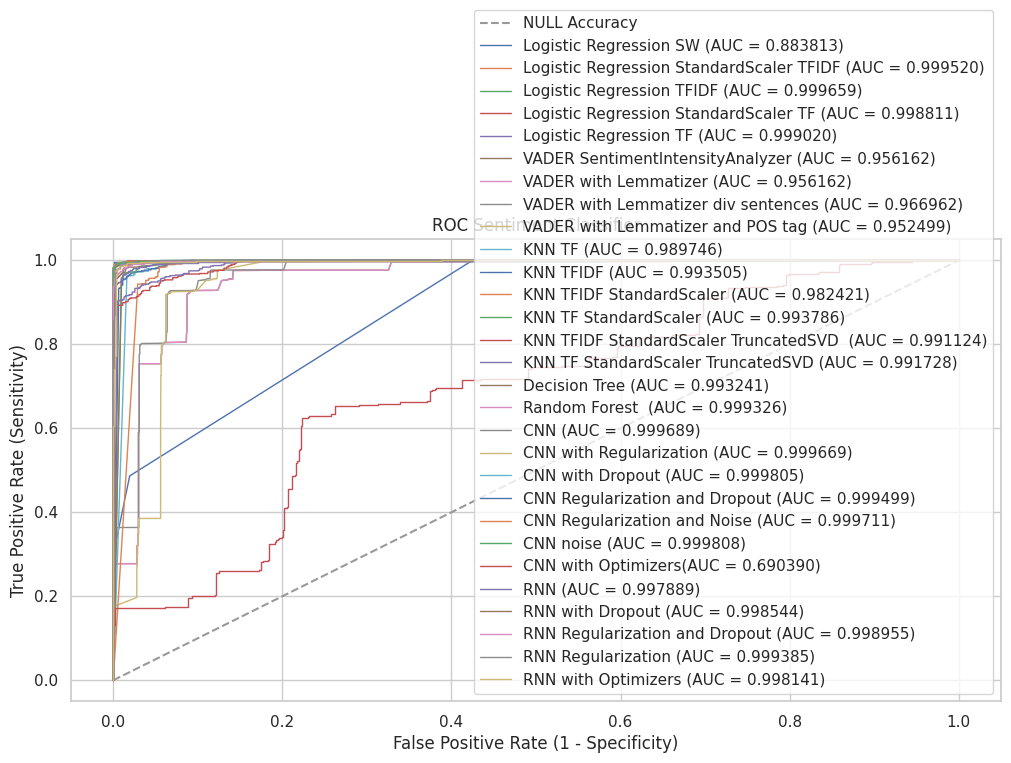

In [181]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_vader_lemmatizer, tpr_vader_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_vader_lemmatizer)
plt.plot(fpr_vader_lemma_div, tpr_vader_lemma_div, lw=1, label='VADER with Lemmatizer div sentences (AUC = %0.6f)' % roc_auc_vader_lemma_div)
plt.plot(fpr_vader_lemma2, tpr_vader_lemma2, lw=1, label='VADER with Lemmatizer and POS tag (AUC = %0.6f)' % roc_auc_vader_lemma2)
plt.plot(fpr_knn_tf, tpr_knn_tf, lw=1, label='KNN TF (AUC = %0.6f)' % roc_auc_knn_tf)
plt.plot(fpr_knn_tfidf, tpr_knn_tfidf, lw=1, label='KNN TFIDF (AUC = %0.6f)' % roc_auc_knn_tfidf)
plt.plot(fpr_knn_ss_tfidf, tpr_knn_ss_tfidf, lw=1, label='KNN TFIDF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tfidf)
plt.plot(fpr_knn_ss_tf, tpr_knn_ss_tf, lw=1, label='KNN TF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tf)
plt.plot(fpr_knn_ss_tsvd_tfidf, tpr_knn_ss_tsvd_tfidf, lw=1, label='KNN TFIDF StandardScaler TruncatedSVD  (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tfidf)
plt.plot(fpr_knn_ss_tsvd_tf, tpr_knn_ss_tsvd_tf, lw=1, label='KNN TF StandardScaler TruncatedSVD (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tf)
plt.plot(fpr_decisiontree, tpr_decisiontree, lw=1, label='Decision Tree (AUC = %0.6f)' % roc_auc_decisiontree)
plt.plot(fpr_randomforest, tpr_randomforest, lw=1, label='Random Forest  (AUC = %0.6f)' % roc_auc_randomforest)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='CNN (AUC = %0.6f)' % roc_auc_cnn)
plt.plot(fpr_cnn_reg, tpr_cnn_reg, lw=1, label='CNN with Regularization (AUC = %0.6f)' % roc_auc_cnn_reg)
plt.plot(fpr_cnn_cnn_dropout, tpr_cnn_dropout, lw=1, label='CNN with Dropout (AUC = %0.6f)' % roc_auc_cnn_dropout)
plt.plot(fpr_cnn_cnn_reg_dropout, tpr_cnn_reg_dropout, lw=1, label='CNN Regularization and Dropout (AUC = %0.6f)' % roc_auc_cnn_reg_dropout)
plt.plot(fpr_cnn_reg_noise, tpr_cnn_reg_noise, lw=1, label='CNN Regularization and Noise (AUC = %0.6f)' % roc_auc_cnn_reg_noise)
plt.plot(fpr_cnn_noise, tpr_cnn_noise, lw=1, label='CNN noise (AUC = %0.6f)' % roc_auc_cnn_noise)
plt.plot(fpr_cnn_noise_dropout_optimizer, tpr_cnn_noise_dropout_optimizer, lw=1, label='CNN with Optimizers(AUC = %0.6f)' % roc_auc_cnn_noise_dropout_optimizer)
plt.plot(fpr_rnn, tpr_rnn, lw=1, label='RNN (AUC = %0.6f)' % roc_auc_rnn)
plt.plot(fpr_rnn_dropout, tpr_rnn_dropout, lw=1, label='RNN with Dropout (AUC = %0.6f)' % roc_auc_rnn_dropout)
plt.plot(fpr_rnn_reg_dropout, tpr_rnn_reg_dropout, lw=1, label='RNN Regularization and Dropout (AUC = %0.6f)' % roc_auc_rnn_reg_dropout)
plt.plot(fpr_rnn_reg, tpr_rnn_reg, lw=1, label='RNN Regularization (AUC = %0.6f)' % roc_auc_rnn_reg)
plt.plot(fpr_rnn_noise_dropout_optimizer, tpr_rnn_noise_dropout_optimizer, lw=1, label='RNN with Optimizers (AUC = %0.6f)' % roc_auc_rnn_noise_dropout_optimizer)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

# **LSTM - Long short-term memory**

In [182]:
#LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_lstm.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
149/149 [==============================] - 13s 70ms/step - loss: 0.3026 - auc: 0.9619 - val_loss: 0.0943 - val_auc: 0.9930
Epoch 2/5
149/149 [==============================] - 8s 57ms/step - loss: 0.0377 - auc: 0.9991 - val_loss: 0.0512 - val_auc: 0.9971
Epoch 3/5
149/149 [==============================] - 10s 68ms/step - loss: 0.0113 - auc: 0.9997 - val_loss: 0.0436 - val_auc: 0.9976
Epoch 4/5
149/149 [==============================] - 9s 63ms/step - loss: 0.0072 - auc: 0.9995 - val_loss: 0.0412 - val_auc: 0.9988
Epoch 5/5
149/149 [==============================] - 8s 56ms/step - loss: 0.0041 - auc: 1.0000 - val_loss: 0.0405 - val_auc: 0.9987


In [183]:
y_pred_prob_lstm = model_lstm.predict(X_test).flatten()
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

fpr_lstm, tpr_lstm, thresholds = metrics.roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm = metrics.auc(fpr_lstm, tpr_lstm)
print(f"ROC AUC: {roc_auc_lstm}")

74/74 [==============================] - 2s 14ms/step
ROC AUC: 0.9989525045883879


In [184]:
add_model_metrics('LSTM', y_test, y_pred_lstm, y_pred_prob_lstm, "selection")

In [185]:
# Save the entire model as a SavedModel.
model_lstm.save('models/LSTM')

In [186]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a simple LSTM layer
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False  # Set to True if stacking LSTM layers, else False
    ))

    # Adding a Dense layer for output
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_lstm_gs = tuner.get_best_models(num_models=1)[0]
results_lstm_gs = best_model_lstm_gs.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_lstm_gs)

Trial 3 Complete [00h 00m 44s]
val_loss: 0.26684051752090454

Best val_loss So Far: 0.04171087220311165
Total elapsed time: 00h 02m 53s
74/74 [==============================] - 2s 11ms/step - loss: 0.0417 - auc: 0.9981
Test Loss, Test AUC: [0.04171087220311165, 0.9980550408363342]


In [187]:
y_pred_prob_lstm_gs = best_model_lstm_gs.predict(X_test).flatten()  # Get the probabilities
y_pred_lstm_gs = (y_pred_prob_lstm_gs > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_lstm_gs = metrics.roc_auc_score(y_test, y_pred_prob_lstm_gs)
fpr_lstm_gs, tpr_lstm_gs, thresholds = metrics.roc_curve(y_test, y_pred_prob_lstm_gs)
print("ROC AUC Score:", roc_auc_lstm_gs)

74/74 [==============================] - 1s 13ms/step
ROC AUC Score: 0.999332258979065


In [188]:
add_model_metrics('LSTM_gs', y_test, y_pred_lstm_gs, y_pred_prob_lstm_gs, "selection")

In [189]:
# Save the entire model as a SavedModel.
best_model_lstm_gs.save('models/LSTM_gs')

In [190]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a simple LSTM layer
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False  # Set to True if stacking LSTM layers, else False
    ))

    # Adding a Dense layer for output with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_lstm_reg = tuner.get_best_models(num_models=1)[0]
results_lstm_reg = best_model_lstm_reg.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_lstm_reg)

Trial 3 Complete [00h 00m 45s]
val_loss: 0.23074673116207123

Best val_loss So Far: 0.03786081820726395
Total elapsed time: 00h 02m 54s
74/74 [==============================] - 2s 10ms/step - loss: 0.0379 - auc: 0.9977
Test Loss, Test AUC: [0.03786081820726395, 0.9976666569709778]


In [191]:
y_pred_prob_lstm_reg = best_model_lstm_reg.predict(X_test). flatten()  # Get the probabilities
y_pred_lstm_reg = (y_pred_prob_lstm_reg > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_lstm_reg = metrics.roc_auc_score(y_test, y_pred_prob_lstm_reg)
fpr_lstm_reg, tpr_lstm_reg, thresholds = metrics.roc_curve(y_test, y_pred_prob_lstm_reg)
print("ROC AUC Score:", roc_auc_lstm_reg)

74/74 [==============================] - 1s 10ms/step
ROC AUC Score: 0.9988435770028501


In [192]:
add_model_metrics('LSTM_reg', y_test, y_pred_lstm_reg, y_pred_prob_lstm_reg, "selection")

In [193]:
# Save the entire model as a SavedModel.
best_model_lstm_reg.save('models/LSTM_reg')

In [194]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a LSTM layer with dropout and recurrent dropout
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking LSTM layers, else False
        dropout=hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_rate', min_value=0, max_value=0.5, step=0.1)
    ))

    # Adding a Dense layer with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    # Adding dropout after the Dense layer
    model.add(keras.layers.Dropout(hp.Float('dense_dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_lstm_reg_dropout = tuner.get_best_models(num_models=1)[0]
results_lstm_reg_dropout = best_model_lstm_reg_dropout.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_lstm_reg_dropout)

Trial 3 Complete [00h 00m 43s]
val_loss: 0.21108637750148773

Best val_loss So Far: 0.03838447481393814
Total elapsed time: 00h 02m 51s
74/74 [==============================] - 3s 16ms/step - loss: 0.0384 - auc: 0.9986
Test Loss, Test AUC: [0.03838447481393814, 0.9986391663551331]


In [195]:
y_pred_prob_lstm_reg_dropout = best_model_lstm_reg_dropout.predict(X_test).flatten()  # Get the probabilities
y_pred_lstm_reg_dropout = (y_pred_prob_lstm_reg_dropout > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_lstm_reg_dropout = metrics.roc_auc_score(y_test, y_pred_prob_lstm_reg_dropout)
fpr_lstm_reg_dropout, tpr_lstm_reg_dropout, thresholds = metrics.roc_curve(y_test, y_pred_prob_lstm_reg_dropout)
print("ROC AUC Score:", roc_auc_lstm_reg_dropout)

74/74 [==============================] - 1s 10ms/step
ROC AUC Score: 0.9989278839697391


In [196]:
add_model_metrics('LSTM_reg_dropout', y_test, y_pred_lstm_reg_dropout, y_pred_prob_lstm_reg_dropout, "selection")

In [197]:
# Save the entire model as a SavedModel.
best_model_lstm_reg_dropout.save('models/LSTM_reg_dropout')

In [198]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a LSTM layer with dropout and recurrent dropout
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking LSTM layers, else False
        dropout=hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_rate', min_value=0, max_value=0.5, step=0.1)
    ))

    # Adding a Dense layer for output
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Optional: Adding dropout after the Dense layer
    model.add(keras.layers.Dropout(hp.Float('dense_dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_lstm_dropout = tuner.get_best_models(num_models=1)[0]
results_lstm_dropout = best_model_lstm_dropout.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_lstm_dropout)

Trial 3 Complete [00h 00m 45s]
val_loss: 0.2531793415546417

Best val_loss So Far: 0.034548357129096985
Total elapsed time: 00h 02m 54s
74/74 [==============================] - 2s 10ms/step - loss: 0.0345 - auc: 0.9992
Test Loss, Test AUC: [0.034548357129096985, 0.9992494583129883]


In [199]:
y_pred_prob_lstm_dropout = best_model_lstm_dropout.predict(X_test).flatten()  # Get the probabilities
y_pred_lstm_dropout = (y_pred_prob_lstm_dropout > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_lstm_dropout = metrics.roc_auc_score(y_test, y_pred_prob_lstm_dropout)
fpr_lstm_dropout, tpr_lstm_dropout, thresholds = metrics.roc_curve(y_test, y_pred_prob_lstm_dropout)
print("ROC AUC Score:", roc_auc_lstm_dropout)

74/74 [==============================] - 1s 10ms/step
ROC AUC Score: 0.9992837638211199


In [200]:
add_model_metrics('LSTM_dropout', y_test, y_pred_lstm_dropout, y_pred_prob_lstm_dropout, "selection")

In [201]:
# Save the entire model as a SavedModel.
best_model_lstm_dropout.save('models/LSTM_dropout')

In [202]:
def build_model_lstm_noise_dropout_optimizer(hp, vocab_size, max_length):
    model = keras.Sequential(name="model_lstm_noise_dropout_optimizer")
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length, name="embedding_lstm_noise_dropout_optimizer"))

    # Adding an LSTM layer with dynamic unit selection
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units_lstm_noise_dropout_optimizer', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking more LSTM layers, else False
        name="lstm_lstm_noise_dropout_optimizer"
    ))

    # Conditional regularization choice
    reg_type = hp.Choice('reg_type_lstm_noise_dropout_optimizer', ['gaussian_noise', 'dropout'])
    if reg_type == 'gaussian_noise':
        model.add(keras.layers.GaussianNoise(
            hp.Float('noise_level_lstm_noise_dropout_optimizer', min_value=0.0, max_value=0.5, step=0.1),
            name="gaussian_noise_lstm_noise_dropout_optimizer"
        ))
    else:
        model.add(keras.layers.Dropout(
            hp.Float('dropout_rate_lstm_noise_dropout_optimizer', min_value=0.0, max_value=0.5, step=0.1),
            name="dropout_lstm_noise_dropout_optimizer"
        ))

    # Adding a Dense layer with units and activation specified
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units_lstm_noise_dropout_optimizer', min_value=10, max_value=100, step=10),
        activation='relu',
        name="dense_lstm_noise_dropout_optimizer"
    ))

    model.add(keras.layers.Dense(1, activation='sigmoid', name="output_lstm_noise_dropout_optimizer"))

    # Choosing the optimizer and learning rate from a set of options
    optimizer_choice = hp.Choice('optimizer_lstm_noise_dropout_optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    learning_rate = hp.Float('learning_rate_lstm_noise_dropout_optimizer', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, name="sgd_lstm_noise_dropout_optimizer")
    else:
        # Properly instantiate the optimizer with the specified learning rate
        optimizer = keras.optimizers.get({
            'class_name': optimizer_choice,
            'config': {'learning_rate': learning_rate}
        })

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model


vocab_size = 10000  # Example value for vocab size
max_length = 100    # Example value for sequence max length

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model_lstm_noise_dropout_optimizer(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_search_with_reg_optimizer'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_lstm_noise_dropout_optimizer = tuner.get_best_models(num_models=1)[0]
results_lstm_noise_dropout_optimizer = best_model_lstm_noise_dropout_optimizer.evaluate(X_test, y_test)
print("Test Loss, Test AUC_lstm_noise_dropout_optimizer:", results_lstm_noise_dropout_optimizer)

y_pred_prob_lstm_noise_dropout_optimizer = best_model_lstm_noise_dropout_optimizer.predict(X_test).flatten()  # Get probabilities
y_pred_lstm_noise_dropout_optimizer = (y_pred_prob_lstm_noise_dropout_optimizer > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_lstm_noise_dropout_optimizer = metrics.roc_auc_score(y_test, y_pred_prob_lstm_noise_dropout_optimizer)
fpr_lstm_noise_dropout_optimizer, tpr_lstm_noise_dropout_optimizer, thresholds = metrics.roc_curve(y_test,
                                                                                                   y_pred_prob_lstm_noise_dropout_optimizer)
print("ROC AUC Score_lstm_noise_dropout_optimizer:", roc_auc_lstm_noise_dropout_optimizer)


Trial 3 Complete [00h 00m 43s]
val_loss: 0.04723618924617767

Best val_loss So Far: 0.04723618924617767
Total elapsed time: 00h 02m 11s
74/74 [==============================] - 2s 11ms/step - loss: 0.0472 - auc: 0.9974
Test Loss, Test AUC_lstm_noise_dropout_optimizer: [0.04723618924617767, 0.9974364638328552]
74/74 [==============================] - 1s 10ms/step
ROC AUC Score_lstm_noise_dropout_optimizer: 0.9979781249533699


In [203]:
add_model_metrics('LSTM_noise_dropout_optimizer', y_test, y_pred_lstm_noise_dropout_optimizer,
                  y_pred_prob_lstm_noise_dropout_optimizer, "selection")

In [204]:
# Save the entire model as a SavedModel.
best_model_lstm_noise_dropout_optimizer.save('models/LSTM_noise_dropout_optimizer')

In [205]:
#Choose the best LSTM model
select_best_model()

Model name:  log_sw -> SCORE:  0.5856558172549684
Model name:  logreg_standscal_tfidf -> SCORE:  0.6634693039229053
Model name:  logreg_tfidf -> SCORE:  0.6635002308707652
Model name:  logreg_standardscaler_tf -> SCORE:  0.6621872876041112
Model name:  logreg_tf -> SCORE:  0.6630818300147374
Model name:  VADER -> SCORE:  0.625226848375504
Model name:  VADER_Lemma -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma_Div -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma2 -> SCORE:  0.6272431514493263
Model name:  KNN_tf -> SCORE:  0.6502105641236328
Model name:  KNN_tfidf -> SCORE:  0.652313120115965
Model name:  KNN_standardscaler_tfidf -> SCORE:  0.6448258014361351
Model name:  KNN_standardscaler_tf -> SCORE:  0.649226854244281
Model name:  KNN_standardscaler_tsvd_tfidf -> SCORE:  0.6422598885815891
Model name:  KNN_standardscaler_tsvd_tf -> SCORE:  0.6429920423879605
Model name:  DecisionTree -> SCORE:  0.6581383669363562
Model name:  RandomForest -> SCORE:  0.6611975205129303


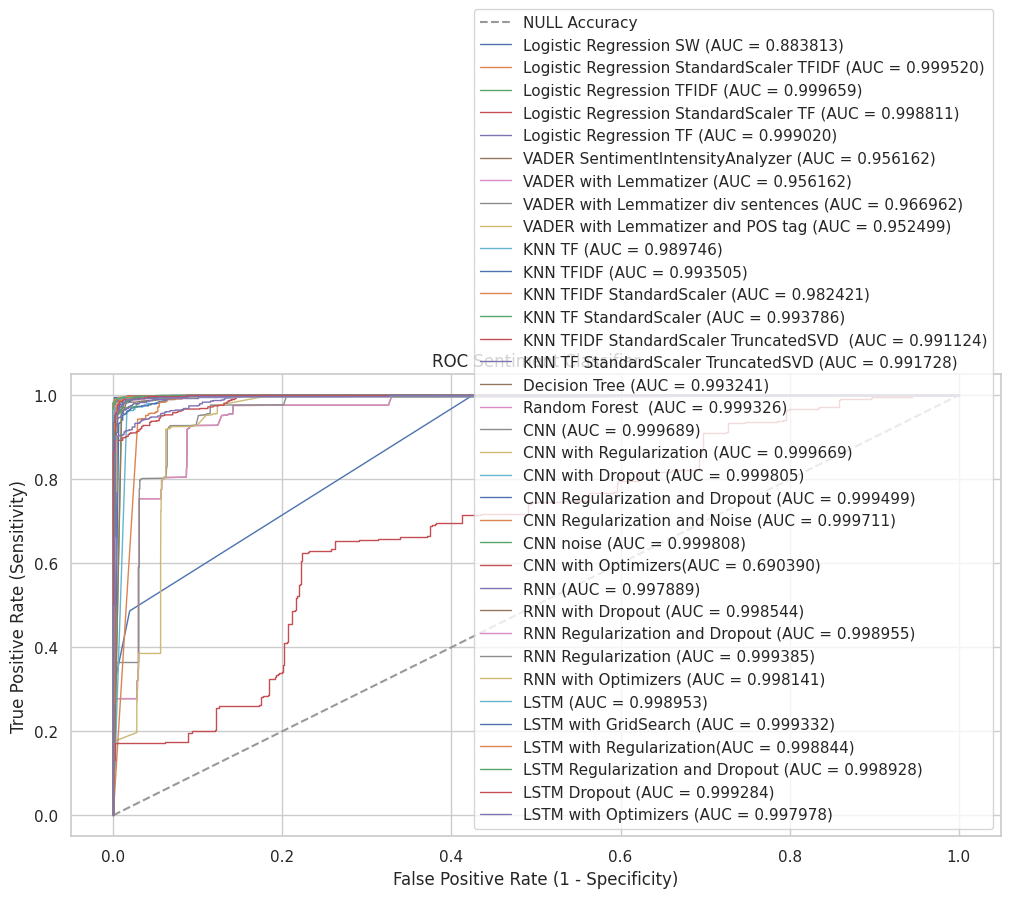

In [206]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_vader_lemmatizer, tpr_vader_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_vader_lemmatizer)
plt.plot(fpr_vader_lemma_div, tpr_vader_lemma_div, lw=1, label='VADER with Lemmatizer div sentences (AUC = %0.6f)' % roc_auc_vader_lemma_div)
plt.plot(fpr_vader_lemma2, tpr_vader_lemma2, lw=1, label='VADER with Lemmatizer and POS tag (AUC = %0.6f)' % roc_auc_vader_lemma2)
plt.plot(fpr_knn_tf, tpr_knn_tf, lw=1, label='KNN TF (AUC = %0.6f)' % roc_auc_knn_tf)
plt.plot(fpr_knn_tfidf, tpr_knn_tfidf, lw=1, label='KNN TFIDF (AUC = %0.6f)' % roc_auc_knn_tfidf)
plt.plot(fpr_knn_ss_tfidf, tpr_knn_ss_tfidf, lw=1, label='KNN TFIDF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tfidf)
plt.plot(fpr_knn_ss_tf, tpr_knn_ss_tf, lw=1, label='KNN TF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tf)
plt.plot(fpr_knn_ss_tsvd_tfidf, tpr_knn_ss_tsvd_tfidf, lw=1, label='KNN TFIDF StandardScaler TruncatedSVD  (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tfidf)
plt.plot(fpr_knn_ss_tsvd_tf, tpr_knn_ss_tsvd_tf, lw=1, label='KNN TF StandardScaler TruncatedSVD (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tf)
plt.plot(fpr_decisiontree, tpr_decisiontree, lw=1, label='Decision Tree (AUC = %0.6f)' % roc_auc_decisiontree)
plt.plot(fpr_randomforest, tpr_randomforest, lw=1, label='Random Forest  (AUC = %0.6f)' % roc_auc_randomforest)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='CNN (AUC = %0.6f)' % roc_auc_cnn)
plt.plot(fpr_cnn_reg, tpr_cnn_reg, lw=1, label='CNN with Regularization (AUC = %0.6f)' % roc_auc_cnn_reg)
plt.plot(fpr_cnn_cnn_dropout, tpr_cnn_dropout, lw=1, label='CNN with Dropout (AUC = %0.6f)' % roc_auc_cnn_dropout)
plt.plot(fpr_cnn_cnn_reg_dropout, tpr_cnn_reg_dropout, lw=1, label='CNN Regularization and Dropout (AUC = %0.6f)' % roc_auc_cnn_reg_dropout)
plt.plot(fpr_cnn_reg_noise, tpr_cnn_reg_noise, lw=1, label='CNN Regularization and Noise (AUC = %0.6f)' % roc_auc_cnn_reg_noise)
plt.plot(fpr_cnn_noise, tpr_cnn_noise, lw=1, label='CNN noise (AUC = %0.6f)' % roc_auc_cnn_noise)
plt.plot(fpr_cnn_noise_dropout_optimizer, tpr_cnn_noise_dropout_optimizer, lw=1, label='CNN with Optimizers(AUC = %0.6f)' % roc_auc_cnn_noise_dropout_optimizer)
plt.plot(fpr_rnn, tpr_rnn, lw=1, label='RNN (AUC = %0.6f)' % roc_auc_rnn)
plt.plot(fpr_rnn_dropout, tpr_rnn_dropout, lw=1, label='RNN with Dropout (AUC = %0.6f)' % roc_auc_rnn_dropout)
plt.plot(fpr_rnn_reg_dropout, tpr_rnn_reg_dropout, lw=1, label='RNN Regularization and Dropout (AUC = %0.6f)' % roc_auc_rnn_reg_dropout)
plt.plot(fpr_rnn_reg, tpr_rnn_reg, lw=1, label='RNN Regularization (AUC = %0.6f)' % roc_auc_rnn_reg)
plt.plot(fpr_rnn_noise_dropout_optimizer, tpr_rnn_noise_dropout_optimizer, lw=1, label='RNN with Optimizers (AUC = %0.6f)' % roc_auc_rnn_noise_dropout_optimizer)
plt.plot(fpr_lstm, tpr_lstm, lw=1, label='LSTM (AUC = %0.6f)' % roc_auc_lstm)
plt.plot(fpr_lstm_gs, tpr_lstm_gs, lw=1, label='LSTM with GridSearch (AUC = %0.6f)' % roc_auc_lstm_gs)
plt.plot(fpr_lstm_reg, tpr_lstm_reg, lw=1, label='LSTM with Regularization(AUC = %0.6f)' % roc_auc_lstm_reg)
plt.plot(fpr_lstm_reg_dropout, tpr_lstm_reg_dropout, lw=1, label='LSTM Regularization and Dropout (AUC = %0.6f)' % roc_auc_lstm_reg_dropout)
plt.plot(fpr_lstm_dropout, tpr_lstm_dropout, lw=1, label='LSTM Dropout (AUC = %0.6f)' % roc_auc_lstm_dropout)
plt.plot(fpr_lstm_noise_dropout_optimizer, tpr_lstm_noise_dropout_optimizer, lw=1, label='LSTM with Optimizers (AUC = %0.6f)' % roc_auc_lstm_noise_dropout_optimizer)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

# **GRU - Gated Recurrent Unit**

In [207]:
#GRU
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_gru.add(GRU(units=50))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_gru.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
149/149 [==============================] - 12s 64ms/step - loss: 0.2620 - auc: 0.9678 - val_loss: 0.0744 - val_auc: 0.9979
Epoch 2/5
149/149 [==============================] - 8s 56ms/step - loss: 0.0254 - auc: 0.9996 - val_loss: 0.0509 - val_auc: 0.9973
Epoch 3/5
149/149 [==============================] - 9s 63ms/step - loss: 0.0078 - auc: 1.0000 - val_loss: 0.0551 - val_auc: 0.9960
Epoch 4/5
149/149 [==============================] - 9s 63ms/step - loss: 0.0069 - auc: 0.9997 - val_loss: 0.0440 - val_auc: 0.9980
Epoch 5/5
149/149 [==============================] - 8s 56ms/step - loss: 0.0023 - auc: 0.9998 - val_loss: 0.0493 - val_auc: 0.9971


In [208]:
y_pred_prob_gru = model_gru.predict(X_test).flatten()
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

fpr_gru, tpr_gru, thresholds = metrics.roc_curve(y_test, y_pred_prob_gru)
roc_auc_gru = metrics.auc(fpr_gru, tpr_gru)
add_model_metrics('GRU', y_test, y_pred_gru, y_pred_prob_gru, "selection")

print(f"ROC AUC: {roc_auc_gru}")

74/74 [==============================] - 2s 17ms/step
ROC AUC: 0.998606323768596


In [209]:
add_model_metrics('GRU', y_test, y_pred_gru,
                  y_pred_prob_gru, "selection")

In [210]:
# Save the entire model as a SavedModel.
model_gru.save('models/GRU')

In [211]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a GRU layer
    model.add(keras.layers.GRU(
        units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
        return_sequences=False  # Set to True if stacking GRU layers, else False
    ))

    # Adding a Dense layer for output
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_gru_gs = tuner.get_best_models(num_models=1)[0]
results_gru_gs = best_model_gru_gs.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_gru_gs)

Trial 3 Complete [00h 00m 46s]
val_loss: 0.13587993383407593

Best val_loss So Far: 0.027272263541817665
Total elapsed time: 00h 02m 17s
74/74 [==============================] - 2s 9ms/step - loss: 0.0273 - auc: 0.9987
Test Loss, Test AUC: [0.027272263541817665, 0.998744010925293]


In [212]:
y_pred_prob_gru_gs = best_model_gru_gs.predict(X_test).flatten()  # Get the probabilities
y_pred_gru_gs = (y_pred_prob_gru_gs > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_gru_gs = metrics.roc_auc_score(y_test, y_pred_prob_gru_gs)
fpr_gru_gs, tpr_gru_gs, thresholds = metrics.roc_curve(y_test, y_pred_prob_gru_gs)
print("ROC AUC Score:", roc_auc_gru_gs)

74/74 [==============================] - 1s 9ms/step
ROC AUC Score: 0.9996403897518541


In [213]:
add_model_metrics('GRU_gs', y_test, y_pred_gru_gs, y_pred_prob_gru_gs, "selection")

In [214]:
# Save the entire model as a SavedModel.
best_model_gru_gs.save('models/GRU_gs')

In [215]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a GRU layer with L1 and L2 regularization
    model.add(keras.layers.GRU(
        units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking GRU layers, else False
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg_gru', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg_gru', min_value=1e-5, max_value=1e-2, sampling='log')
        )
    ))

    # Adding a Dense layer for output with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg_dense', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg_dense', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_gru_reg = tuner.get_best_models(num_models=1)[0]
results_gru_reg = best_model_gru_reg.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_gru_reg)

Trial 3 Complete [00h 01m 26s]
val_loss: 0.13924722373485565

Best val_loss So Far: 0.047979697585105896
Total elapsed time: 00h 02m 56s
74/74 [==============================] - 2s 10ms/step - loss: 0.0480 - auc: 0.9988
Test Loss, Test AUC: [0.047979697585105896, 0.9987562894821167]


In [216]:
y_pred_prob_gru_reg = best_model_gru_reg.predict(X_test).flatten()  # Get the probabilities
y_pred_gru_reg = (y_pred_prob_gru_reg > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_gru_reg = metrics.roc_auc_score(y_test, y_pred_prob_gru_reg)
fpr_gru_reg, tpr_gru_reg, thresholds = metrics.roc_curve(y_test, y_pred_prob_gru_reg)
print("ROC AUC Score:", roc_auc_gru_reg)

74/74 [==============================] - 1s 10ms/step
ROC AUC Score: 0.998595878657654


In [217]:
add_model_metrics('GRU_reg', y_test, y_pred_gru_reg, y_pred_prob_gru_reg, "selection")

In [218]:
# Save the entire model as a SavedModel.
best_model_gru_reg.save('models/GRU_reg')

In [219]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a GRU layer with dropout and recurrent dropout
    model.add(keras.layers.GRU(
        units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking GRU layers, else False
        dropout=hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_rate', min_value=0, max_value=0.5, step=0.1)
    ))

    # Adding a Dense layer for output
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Optional: Adding dropout after the Dense layer
    model.add(keras.layers.Dropout(hp.Float('dense_dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_gru_dropout = tuner.get_best_models(num_models=1)[0]
results_gru_dropout = best_model_gru_dropout.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_gru_dropout)

Trial 3 Complete [00h 01m 25s]
val_loss: 0.12698864936828613

Best val_loss So Far: 0.03147447854280472
Total elapsed time: 00h 03m 37s
74/74 [==============================] - 2s 10ms/step - loss: 0.0315 - auc: 0.9987
Test Loss, Test AUC: [0.03147447854280472, 0.9986895322799683]


In [220]:
y_pred_prob_gru_dropout = best_model_gru_dropout.predict(X_test).flatten()  # Get the probabilities
y_pred_gru_dropout = (y_pred_prob_gru_dropout > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_gru_dropout = metrics.roc_auc_score(y_test, y_pred_prob_gru_dropout)
fpr_gru_dropout, tpr_gru_dropout, thresholds = metrics.roc_curve(y_test, y_pred_prob_gru_dropout)
print("ROC AUC Score:", roc_auc_gru_dropout)

74/74 [==============================] - 1s 9ms/step
ROC AUC Score: 0.999505349388961


In [221]:
add_model_metrics('GRU_dropout', y_test, y_pred_gru_dropout, y_pred_prob_gru_dropout, "selection")

In [222]:
# Save the entire model as a SavedModel.
best_model_gru_dropout.save('models/GRU_dropout')

In [223]:
def build_model(hp, vocab_size, max_length):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

    # Adding a GRU layer with dropout, recurrent dropout and L1, L2 regularization
    model.add(keras.layers.GRU(
        units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking GRU layers, else False
        dropout=hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_rate', min_value=0, max_value=0.5, step=0.1),
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )
    ))

    # Adding a Dense layer for output with L1 and L2 regularization
    model.add(keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')
        )))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['AUC'])
    return model

# Assume vocab_size and max_length are defined based on your dataset
vocab_size = 10000  # example value
max_length = 100    # example value

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model(hp, vocab_size, max_length),
    objective="val_loss",  # Updated objective to AUC, common in binary classification
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_search'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_gru_reg_dropout = tuner.get_best_models(num_models=1)[0]
results_gru_reg_dropout = best_model_gru_reg_dropout.evaluate(X_test, y_test)
print("Test Loss, Test AUC:", results_gru_reg_dropout)

Trial 3 Complete [00h 00m 45s]
val_loss: 0.12960495054721832

Best val_loss So Far: 0.03969356417655945
Total elapsed time: 00h 02m 57s
74/74 [==============================] - 2s 10ms/step - loss: 0.0397 - auc: 0.9978
Test Loss, Test AUC: [0.03969356417655945, 0.9978241324424744]


In [224]:
y_pred_prob_gru_reg_dropout = best_model_gru_reg_dropout.predict(X_test).flatten()  # Get the probabilities
y_pred_gru_reg_dropout = (y_pred_prob_gru_reg_dropout > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_gru_reg_dropout = metrics.roc_auc_score(y_test, y_pred_prob_gru_reg_dropout)
fpr_gru_reg_dropout, tpr_gru_reg_dropout, thresholds = metrics.roc_curve(y_test, y_pred_prob_gru_reg_dropout)
print("ROC AUC Score:", roc_auc_gru_reg_dropout)

74/74 [==============================] - 1s 10ms/step
ROC AUC Score: 0.999460584627781


In [225]:
add_model_metrics('GRU_reg_dropout', y_test, y_pred_gru_reg_dropout,
                  y_pred_prob_gru_reg_dropout, "selection")

In [226]:
# Save the entire model as a SavedModel.
best_model_gru_reg_dropout.save('models/GRU_reg_dropout')

In [227]:
def build_model_gru_noise_dropout_optimizer(hp, vocab_size, max_length):
    model = keras.Sequential(name="model_gru_noise_dropout_optimizer")
    model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length, name="embedding_gru_noise_dropout_optimizer"))

    # Adding a GRU layer with dynamic unit selection
    model.add(keras.layers.GRU(
        units=hp.Int('gru_units_gru_noise_dropout_optimizer', min_value=32, max_value=256, step=32),
        return_sequences=False,  # Set to True if stacking more GRU layers, else False
        name="gru_gru_noise_dropout_optimizer"
    ))

    # Conditional regularization choice
    reg_type = hp.Choice('reg_type_gru_noise_dropout_optimizer', ['gaussian_noise', 'dropout'])
    if reg_type == 'gaussian_noise':
        model.add(keras.layers.GaussianNoise(
            hp.Float('noise_level_gru_noise_dropout_optimizer', min_value=0.0, max_value=0.5, step=0.1),
            name="gaussian_noise_gru_noise_dropout_optimizer"
        ))
    else:
        model.add(keras.layers.Dropout(
            hp.Float('dropout_rate_gru_noise_dropout_optimizer', min_value=0.0, max_value=0.5, step=0.1),
            name="dropout_gru_noise_dropout_optimizer"
        ))

    # Adding a Dense layer for output
    model.add(keras.layers.Dense(1, activation='sigmoid', name="output_gru_noise_dropout_optimizer"))

    # Choosing the optimizer and learning rate from a set of options
    optimizer_choice = hp.Choice('optimizer_gru_noise_dropout_optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    learning_rate = hp.Float('learning_rate_gru_noise_dropout_optimizer', min_value=1e-4, max_value=1e-2, sampling='log')
    if optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, name="sgd_gru_noise_dropout_optimizer")
    else:
        # Properly instantiate the optimizer with the specified learning rate
        optimizer = keras.optimizers.get({
            'class_name': optimizer_choice,
            'config': {'learning_rate': learning_rate}
        })

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

vocab_size = 10000  # Example value for vocab size
max_length = 100    # Example value for sequence max length

tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model_gru_noise_dropout_optimizer(hp, vocab_size, max_length),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_search_with_reg_optimizer'
)

# Ensure X_train, y_train, X_test, y_test are defined and preprocessed appropriately
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model_gru_noise_dropout_optimizer = tuner.get_best_models(num_models=1)[0]
results_gru_noise_dropout_optimizer = best_model_gru_noise_dropout_optimizer.evaluate(X_test, y_test)
print("Test Loss, Test AUC_gru_noise_dropout_optimizer:", results_gru_noise_dropout_optimizer)

Trial 3 Complete [00h 01m 25s]
val_loss: 0.051606737077236176

Best val_loss So Far: 0.041995201259851456
Total elapsed time: 00h 03m 33s
74/74 [==============================] - 2s 10ms/step - loss: 0.0420 - auc: 0.9987
Test Loss, Test AUC_gru_noise_dropout_optimizer: [0.041995201259851456, 0.9986987113952637]


In [228]:
y_pred_prob_gru_noise_dropout_optimizer = best_model_gru_noise_dropout_optimizer.predict(X_test).flatten()  # Get the probabilities
y_pred_gru_noise_dropout_optimizer = (y_pred_prob_gru_noise_dropout_optimizer > 0.5).astype(int)  # Convert probabilities to binary class labels

roc_auc_gru_noise_dropout_optimizer = metrics.roc_auc_score(y_test, y_pred_prob_gru_noise_dropout_optimizer)
fpr_gru_noise_dropout_optimizer, tpr_gru_noise_dropout_optimizer, thresholds = metrics.roc_curve(y_test, y_pred_prob_gru_noise_dropout_optimizer)
print("ROC AUC Score_gru_noise_dropout_optimizer:", roc_auc_gru_noise_dropout_optimizer)

74/74 [==============================] - 1s 9ms/step
ROC AUC Score_gru_noise_dropout_optimizer: 0.9986831699419549


In [229]:
add_model_metrics('GRU_noise_dropout_optimizert', y_test,
                  y_pred_gru_noise_dropout_optimizer, y_pred_prob_gru_noise_dropout_optimizer,
                  "selection")

In [230]:
# Save the entire model as a SavedModel.
best_model_gru_noise_dropout_optimizer.save('models/GRU_noise_dropout_optimizert')

In [231]:
#Choose the best GRU model
select_best_model()

Model name:  log_sw -> SCORE:  0.5856558172549684
Model name:  logreg_standscal_tfidf -> SCORE:  0.6634693039229053
Model name:  logreg_tfidf -> SCORE:  0.6635002308707652
Model name:  logreg_standardscaler_tf -> SCORE:  0.6621872876041112
Model name:  logreg_tf -> SCORE:  0.6630818300147374
Model name:  VADER -> SCORE:  0.625226848375504
Model name:  VADER_Lemma -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma_Div -> SCORE:  0.6317861877700572
Model name:  VADER_Lemma2 -> SCORE:  0.6272431514493263
Model name:  KNN_tf -> SCORE:  0.6502105641236328
Model name:  KNN_tfidf -> SCORE:  0.652313120115965
Model name:  KNN_standardscaler_tfidf -> SCORE:  0.6448258014361351
Model name:  KNN_standardscaler_tf -> SCORE:  0.649226854244281
Model name:  KNN_standardscaler_tsvd_tfidf -> SCORE:  0.6422598885815891
Model name:  KNN_standardscaler_tsvd_tf -> SCORE:  0.6429920423879605
Model name:  DecisionTree -> SCORE:  0.6581383669363562
Model name:  RandomForest -> SCORE:  0.6611975205129303


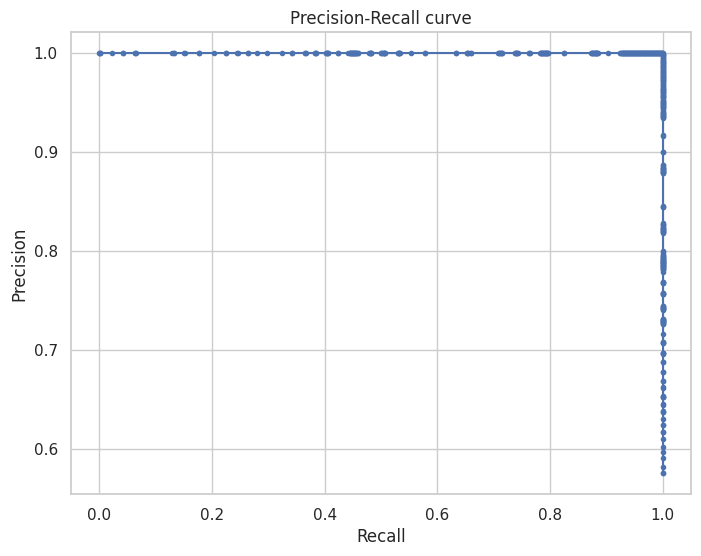

In [232]:
# Obliczanie wartości dla krzywej PR
precision, recall, thresholds = metrics.precision_recall_curve(y_pred_gru, y_pred_prob_gru)

# Rysowanie krzywej PR
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

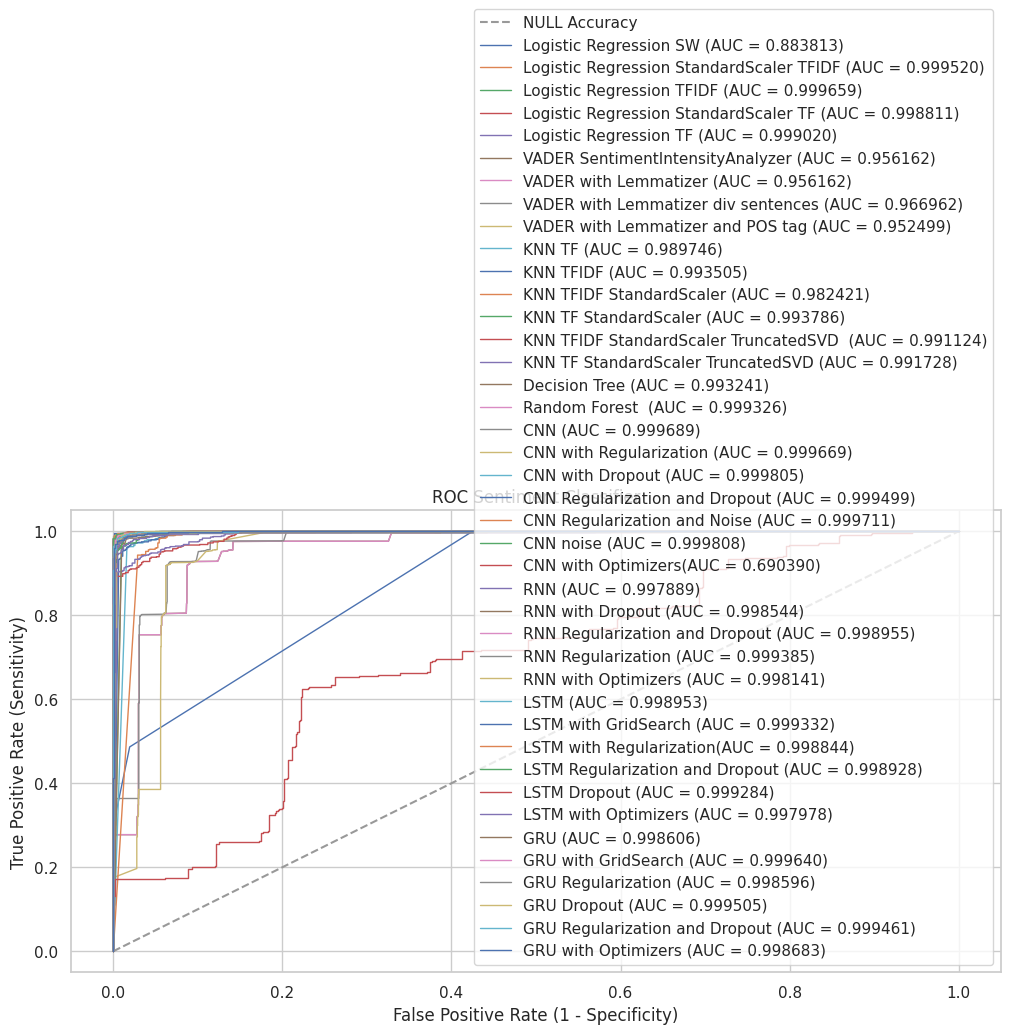

In [233]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_ss_tf, tpr_lr_ss_tf, lw=1, label='Logistic Regression StandardScaler TF (AUC = %0.6f)' % roc_auc_lr_ss_tf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_vader_lemmatizer, tpr_vader_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_vader_lemmatizer)
plt.plot(fpr_vader_lemma_div, tpr_vader_lemma_div, lw=1, label='VADER with Lemmatizer div sentences (AUC = %0.6f)' % roc_auc_vader_lemma_div)
plt.plot(fpr_vader_lemma2, tpr_vader_lemma2, lw=1, label='VADER with Lemmatizer and POS tag (AUC = %0.6f)' % roc_auc_vader_lemma2)
plt.plot(fpr_knn_tf, tpr_knn_tf, lw=1, label='KNN TF (AUC = %0.6f)' % roc_auc_knn_tf)
plt.plot(fpr_knn_tfidf, tpr_knn_tfidf, lw=1, label='KNN TFIDF (AUC = %0.6f)' % roc_auc_knn_tfidf)
plt.plot(fpr_knn_ss_tfidf, tpr_knn_ss_tfidf, lw=1, label='KNN TFIDF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tfidf)
plt.plot(fpr_knn_ss_tf, tpr_knn_ss_tf, lw=1, label='KNN TF StandardScaler (AUC = %0.6f)' % roc_auc_knn_ss_tf)
plt.plot(fpr_knn_ss_tsvd_tfidf, tpr_knn_ss_tsvd_tfidf, lw=1, label='KNN TFIDF StandardScaler TruncatedSVD  (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tfidf)
plt.plot(fpr_knn_ss_tsvd_tf, tpr_knn_ss_tsvd_tf, lw=1, label='KNN TF StandardScaler TruncatedSVD (AUC = %0.6f)' % roc_auc_knn_ss_tsvd_tf)
plt.plot(fpr_decisiontree, tpr_decisiontree, lw=1, label='Decision Tree (AUC = %0.6f)' % roc_auc_decisiontree)
plt.plot(fpr_randomforest, tpr_randomforest, lw=1, label='Random Forest  (AUC = %0.6f)' % roc_auc_randomforest)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='CNN (AUC = %0.6f)' % roc_auc_cnn)
plt.plot(fpr_cnn_reg, tpr_cnn_reg, lw=1, label='CNN with Regularization (AUC = %0.6f)' % roc_auc_cnn_reg)
plt.plot(fpr_cnn_cnn_dropout, tpr_cnn_dropout, lw=1, label='CNN with Dropout (AUC = %0.6f)' % roc_auc_cnn_dropout)
plt.plot(fpr_cnn_cnn_reg_dropout, tpr_cnn_reg_dropout, lw=1, label='CNN Regularization and Dropout (AUC = %0.6f)' % roc_auc_cnn_reg_dropout)
plt.plot(fpr_cnn_reg_noise, tpr_cnn_reg_noise, lw=1, label='CNN Regularization and Noise (AUC = %0.6f)' % roc_auc_cnn_reg_noise)
plt.plot(fpr_cnn_noise, tpr_cnn_noise, lw=1, label='CNN noise (AUC = %0.6f)' % roc_auc_cnn_noise)
plt.plot(fpr_cnn_noise_dropout_optimizer, tpr_cnn_noise_dropout_optimizer, lw=1, label='CNN with Optimizers(AUC = %0.6f)' % roc_auc_cnn_noise_dropout_optimizer)
plt.plot(fpr_rnn, tpr_rnn, lw=1, label='RNN (AUC = %0.6f)' % roc_auc_rnn)
plt.plot(fpr_rnn_dropout, tpr_rnn_dropout, lw=1, label='RNN with Dropout (AUC = %0.6f)' % roc_auc_rnn_dropout)
plt.plot(fpr_rnn_reg_dropout, tpr_rnn_reg_dropout, lw=1, label='RNN Regularization and Dropout (AUC = %0.6f)' % roc_auc_rnn_reg_dropout)
plt.plot(fpr_rnn_reg, tpr_rnn_reg, lw=1, label='RNN Regularization (AUC = %0.6f)' % roc_auc_rnn_reg)
plt.plot(fpr_rnn_noise_dropout_optimizer, tpr_rnn_noise_dropout_optimizer, lw=1, label='RNN with Optimizers (AUC = %0.6f)' % roc_auc_rnn_noise_dropout_optimizer)
plt.plot(fpr_lstm, tpr_lstm, lw=1, label='LSTM (AUC = %0.6f)' % roc_auc_lstm)
plt.plot(fpr_lstm_gs, tpr_lstm_gs, lw=1, label='LSTM with GridSearch (AUC = %0.6f)' % roc_auc_lstm_gs)
plt.plot(fpr_lstm_reg, tpr_lstm_reg, lw=1, label='LSTM with Regularization(AUC = %0.6f)' % roc_auc_lstm_reg)
plt.plot(fpr_lstm_reg_dropout, tpr_lstm_reg_dropout, lw=1, label='LSTM Regularization and Dropout (AUC = %0.6f)' % roc_auc_lstm_reg_dropout)
plt.plot(fpr_lstm_dropout, tpr_lstm_dropout, lw=1, label='LSTM Dropout (AUC = %0.6f)' % roc_auc_lstm_dropout)
plt.plot(fpr_lstm_noise_dropout_optimizer, tpr_lstm_noise_dropout_optimizer, lw=1, label='LSTM with Optimizers (AUC = %0.6f)' % roc_auc_lstm_noise_dropout_optimizer)
plt.plot(fpr_gru, tpr_gru, lw=1, label='GRU (AUC = %0.6f)' % roc_auc_gru)
plt.plot(fpr_gru_gs, tpr_gru_gs, lw=1, label='GRU with GridSearch (AUC = %0.6f)' % roc_auc_gru_gs)
plt.plot(fpr_gru_reg, tpr_gru_reg, lw=1, label='GRU Regularization (AUC = %0.6f)' % roc_auc_gru_reg)
plt.plot(fpr_gru_dropout, tpr_gru_dropout, lw=1, label='GRU Dropout (AUC = %0.6f)' % roc_auc_gru_dropout)
plt.plot(fpr_gru_reg_dropout, tpr_gru_reg_dropout, lw=1, label='GRU Regularization and Dropout (AUC = %0.6f)' % roc_auc_gru_reg_dropout)
plt.plot(fpr_gru_noise_dropout_optimizer, tpr_gru_noise_dropout_optimizer, lw=1, label='GRU with Optimizers (AUC = %0.6f)' % roc_auc_gru_noise_dropout_optimizer)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [234]:
df_model_metrics = pd.DataFrame(model_metrics).T
df_model_metrics

y_pred  \
logreg_tfidf     [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, ...   
CNN_reg_dropout  [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, ...   

                                                           y_probs       auc  \
logreg_tfidf     [0.9999999999513245, 0.0001680729352981036, 0....  0.999659   
CNN_reg_dropout  [0.9998137, 0.00033644566, 0.99998707, 0.00042...  0.999499   

                precision    recall  f1_score   roc_auc    pr_auc  log_loss  
logreg_tfidf      0.99493  0.991162  0.993042  0.992386   0.99974  0.023351  
CNN_reg_dropout  0.995509  0.996255  0.995882  0.995139  0.999725  0.014828

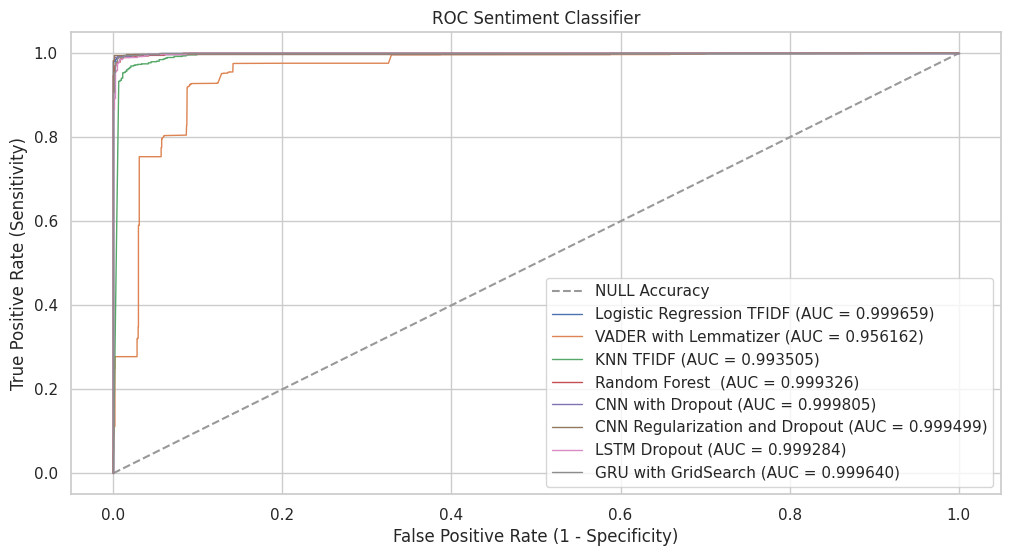

In [236]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_vader_lemmatizer, tpr_vader_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_vader_lemmatizer)
plt.plot(fpr_knn_tfidf, tpr_knn_tfidf, lw=1, label='KNN TFIDF (AUC = %0.6f)' % roc_auc_knn_tfidf)
plt.plot(fpr_randomforest, tpr_randomforest, lw=1, label='Random Forest  (AUC = %0.6f)' % roc_auc_randomforest)
plt.plot(fpr_cnn_cnn_dropout, tpr_cnn_dropout, lw=1, label='CNN with Dropout (AUC = %0.6f)' % roc_auc_cnn_dropout)
plt.plot(fpr_cnn_cnn_reg_dropout, tpr_cnn_reg_dropout, lw=1, label='CNN Regularization and Dropout (AUC = %0.6f)' % roc_auc_cnn_reg_dropout)
plt.plot(fpr_lstm_dropout, tpr_lstm_dropout, lw=1, label='LSTM Dropout (AUC = %0.6f)' % roc_auc_lstm_dropout)
plt.plot(fpr_gru_gs, tpr_gru_gs, lw=1, label='GRU with GridSearch (AUC = %0.6f)' % roc_auc_gru_gs)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

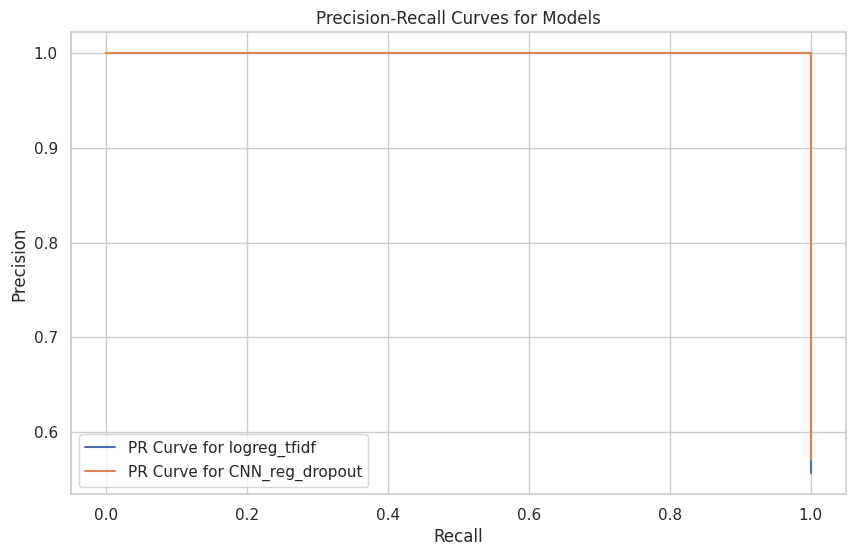

In [237]:
# Accessing model probabilities and plotting PR curves
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model_data in model_metrics.items():
  if 'y_probs' in model_data and 'y_pred' in model_data:
    # Extract probabilities and true labels
    y_scores = np.array(model_data['y_probs'])
    y_true = np.array(model_data['y_pred'])  # Only if y_pred corresponds to true labels

    # Compute precision-recall values
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_scores)

    # Plot the precision-recall curve for the model
    ax.plot(recall, precision, label=f'PR Curve for {model_name}')
  else:
    print(f"Error: Missing 'y_probs' or 'y_pred' for {model_name}")

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves for Models')
ax.legend(loc="best")
plt.show()


In [238]:
def plot_performance_metrics(df_model_metrics):
    # Suppress future warnings locally
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)

        # Set the aesthetic style of the plots
        sns.set(style="whitegrid")

        # Define a list of metrics to be plotted
        metrics_to_plot = ['auc', 'precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc']

        # Filter the DataFrame to include only the specified metrics
        filtered_metrics = df_model_metrics[metrics_to_plot]

        # Check the number of models (columns) after filtering
        num_models = len(df_model_metrics)

        # Single plot for one model with multiple metrics or multiple plots if multiple models
        if num_models == 1:
          # Single model case
          fig, ax = plt.subplots(figsize=(8, 4))
          sns.barplot(data=filtered_metrics, ax=ax, palette='viridis')
          ax.set_title('Performance Metrics for the Model')
          ax.set_ylabel('Value')
          ax.set_xlabel('Metric')
          ax.tick_params(axis='x', rotation=45)
          # Annotate the bars
          # for p in ax.patches:
          #   ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 10), textcoords='offset points')
          for p in ax.patches:
                value = p.get_height()
                x = p.get_x() + p.get_width() / 2
                # Adjusting y to ensure the annotation always fits within the plot area
                if value >= ax.get_ylim()[1] * 0.9:  # If value is within the top 5% of the y-axis
                    y = ax.get_ylim()[1] * 0.85  # Lower the annotation to 95% of the y-axis height
                else:
                    y = value + 0.01 * ax.get_ylim()[1]  # Else, slightly above the bar
                ax.annotate(f"{value:.2f}", (x, y), ha='center', va='bottom', fontsize=10, color='#06172a', xytext=(0, 3), textcoords='offset points')
        else:
          # Multiple models case
          fig, axes = plt.subplots(figsize=(20, 6))
          melted_df = filtered_metrics.reset_index().melt(id_vars='index')
          sns.barplot(x='variable', y='value', hue='index', data=melted_df, ax=axes, palette='viridis')
          axes.set_title('Performance Metrics Comparison Across Models')
          axes.set_ylabel('Value')
          axes.set_xlabel('Metric')
          axes.tick_params(axis='x', rotation=45)
          axes.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

          for p in axes.patches:
                value = p.get_height()
                x = p.get_x() + p.get_width() / 2
                # Adjusting y to ensure the annotation always fits within the plot area
                if value >= axes.get_ylim()[1] * 0.9:  # If value is within the top 5% of the y-axis
                    y = axes.get_ylim()[1] * 0.85  # Lower the annotation to 95% of the y-axis height
                else:
                    y = value + 0.01 * axes.get_ylim()[1]  # Else, slightly above the bar
                axes.annotate(f"{value:.2f}", (x, y), ha='center', va='bottom', fontsize=10, color='#06172a', xytext=(0, 3), textcoords='offset points')



        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


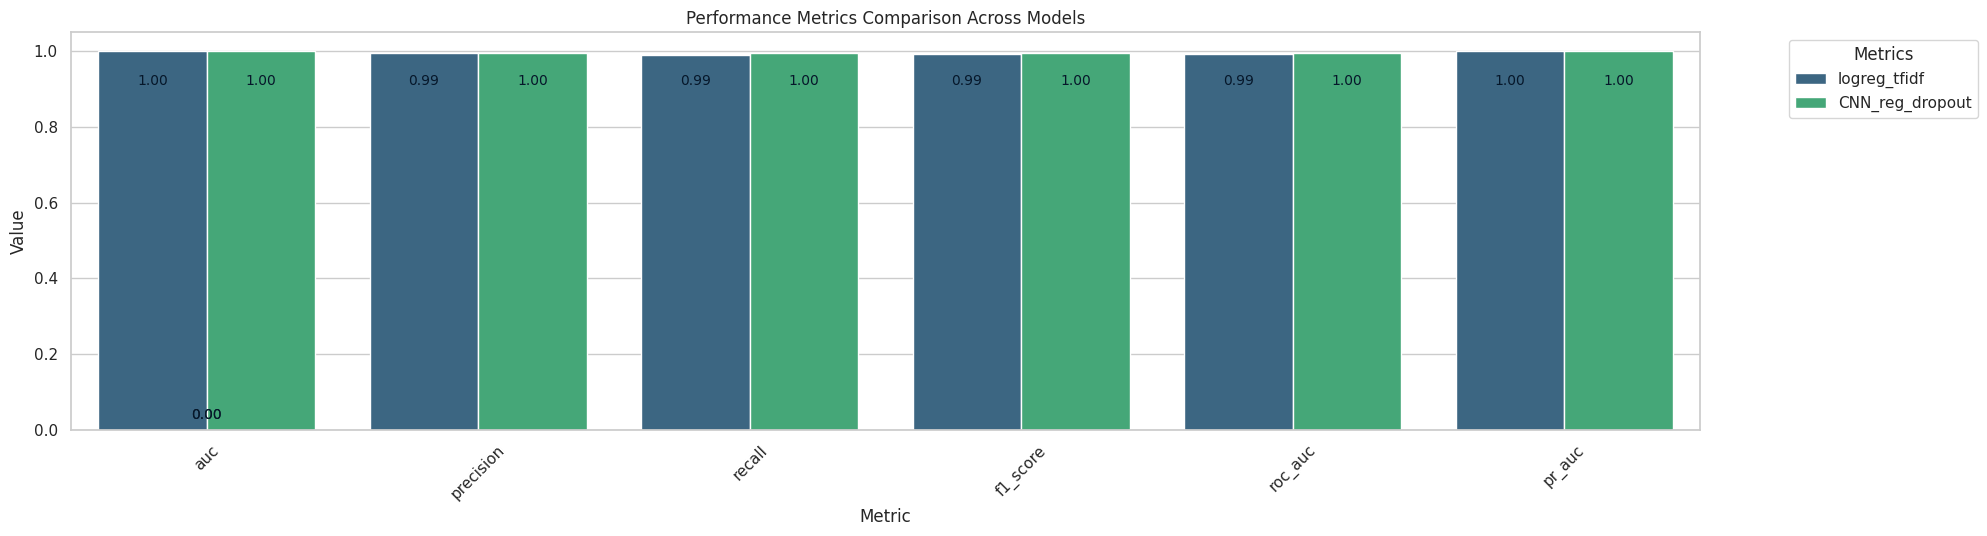

In [239]:
#df_model_metrics = df_model_metrics.T
plot_performance_metrics(df_model_metrics)

Selected top model: CNN_reg_dropout
Model metrics:
y_pred: [1 0 1 ... 1 1 0]
y_probs: [9.9981368e-01 3.3644566e-04 9.9998707e-01 ... 9.9977189e-01 9.9833685e-01
 3.1065373e-04]
auc: 0.9994986346747841
precision: 0.9955089820359282
recall: 0.9962546816479401
f1_score: 0.9958816922500936
roc_auc: 0.9951392930152051
pr_auc: 0.9997246349462716
log_loss: 0.014827902505575582
Score: 0.6647249551908117
Selected top model: CNN_noise
Model metrics:
y_pred: [1 0 1 ... 1 1 0]
y_probs: [9.9999833e-01 9.8327735e-05 9.9999851e-01 ... 9.9999642e-01 9.9997425e-01
 1.7046810e-05]
auc: 0.999808257606279
precision: 0.9940074906367041
recall: 0.9940074906367041
f1_score: 0.9940074906367041
roc_auc: 0.9930196815733321
pr_auc: 0.9998589523021305
log_loss: 0.020177216029920706
Score: 0.6639607197510417
Selected top model: CNN_reg_noise
Model metrics:
y_pred: [1 0 1 ... 1 1 0]
y_probs: [9.9996173e-01 2.3006387e-04 9.9997157e-01 ... 9.9981922e-01 9.9969065e-01
 1.7430949e-04]
auc: 0.9997112672903891
precision:

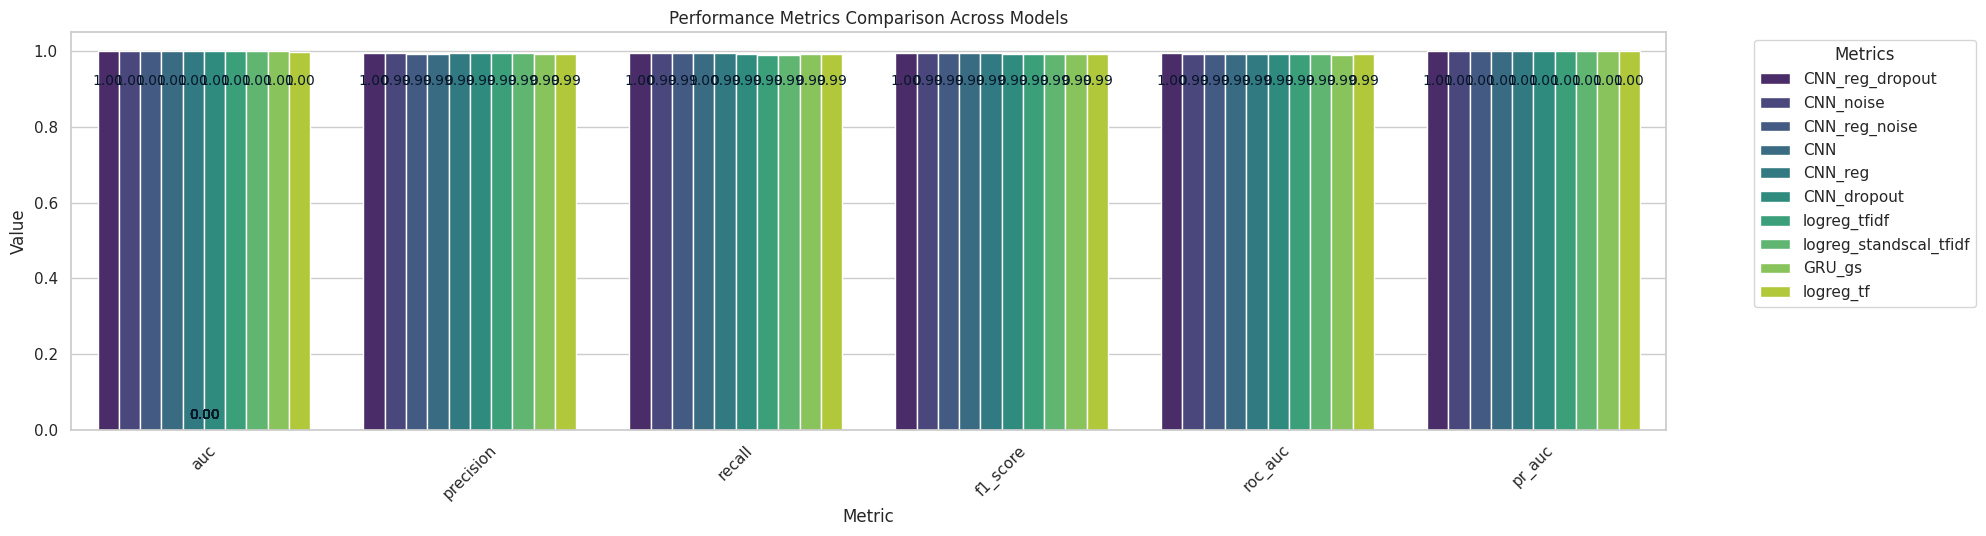

In [246]:
top_10_model_of_all = select_top_best_models(metrics_dict=model_metrics_temp, drop=False, top_n=10)
plot_performance_metrics(pd.DataFrame.from_dict(top_10_model_of_all, orient='index'))

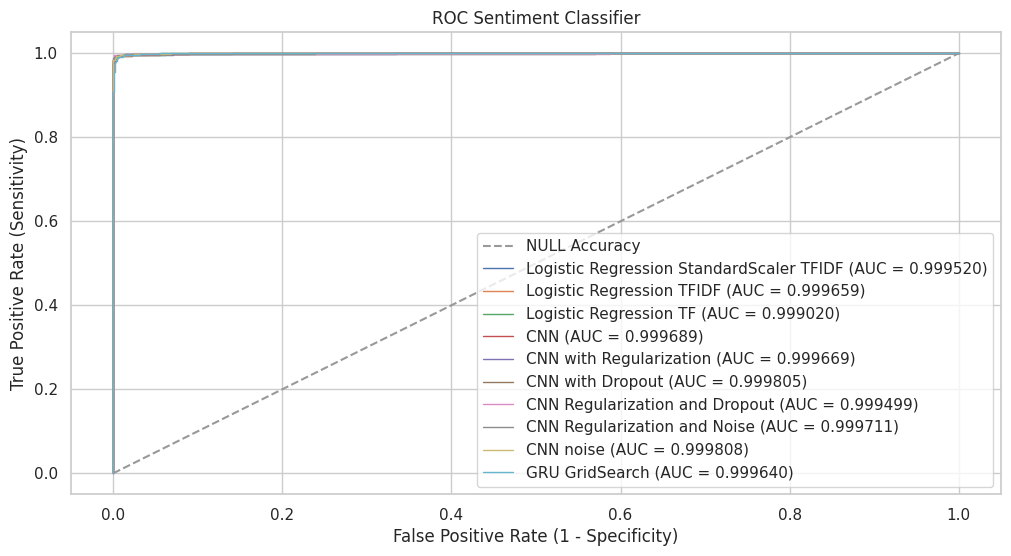

In [247]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_lr_ss_tfidf, tpr_lr_ss_tfidf, lw=1, label='Logistic Regression StandardScaler TFIDF (AUC = %0.6f)' % roc_auc_lr_ss_tfidf)
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, lw=1, label='Logistic Regression TFIDF (AUC = %0.6f)' % roc_auc_lr_tfidf)
plt.plot(fpr_lr_tf, tpr_lr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_lr_tf)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='CNN (AUC = %0.6f)' % roc_auc_cnn)
plt.plot(fpr_cnn_reg, tpr_cnn_reg, lw=1, label='CNN with Regularization (AUC = %0.6f)' % roc_auc_cnn_reg)
plt.plot(fpr_cnn_cnn_dropout, tpr_cnn_dropout, lw=1, label='CNN with Dropout (AUC = %0.6f)' % roc_auc_cnn_dropout)
plt.plot(fpr_cnn_cnn_reg_dropout, tpr_cnn_reg_dropout, lw=1, label='CNN Regularization and Dropout (AUC = %0.6f)' % roc_auc_cnn_reg_dropout)
plt.plot(fpr_cnn_reg_noise, tpr_cnn_reg_noise, lw=1, label='CNN Regularization and Noise (AUC = %0.6f)' % roc_auc_cnn_reg_noise)
plt.plot(fpr_cnn_noise, tpr_cnn_noise, lw=1, label='CNN noise (AUC = %0.6f)' % roc_auc_cnn_noise)
plt.plot(fpr_gru_gs, tpr_gru_gs, lw=1, label='GRU GridSearch (AUC = %0.6f)' % roc_auc_gru_gs)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [240]:
def select_top_best_models(metrics_dict=None, drop=True, top_n=3):
    # Use a global dictionary if none is provided
    if metrics_dict is None:
        global model_metrics_temp
        metrics_dict = model_metrics_temp

    # Add calculated scores to each model's metrics
    for model_name, model_measures in metrics_dict.items():
        weights = {'Precision': 0.2, 'Recall': 0.2, 'F1 Score': 0.3, 'Auc': 0.2}
        normalized_measures = {key.capitalize(): value for key, value in model_measures.items() if key.capitalize() in weights}
        model_measures['Score'] = calculate_aggregated_metric_from_dict(normalized_measures, weights)

    # Sort and select the top models based on the newly added 'Score'
    best_models = sorted(metrics_dict.items(), key=lambda x: x[1]['Score'], reverse=True)[:top_n]
    top_models_dict = {model_name: measures for model_name, measures in best_models}

    # Display metrics for the top models
    if top_models_dict:
        for model_name, measures in top_models_dict.items():
            print(f"Selected top model: {model_name}")
            print("Model metrics:")
            print(*(f"{k}: {v}" for k, v in measures.items() if k != 'Score'), sep="\n")
            print("Score:", measures['Score'])
    else:
        print("No valid models were found.")

    # Optionally clear the original metrics dictionary
    if drop:
        metrics_dict.clear()

    # Return the dictionary containing only the best models
    return top_models_dict

def calculate_weighted_score(metrics, weights):
    total_weight = sum(weights.values())
    aggregated_score = sum(metrics[metric] * weights[metric] for metric in metrics if metric in weights)

    if total_weight == 0:
        raise ValueError("The sum of the weights cannot be equal to zero.")

    return aggregated_score / total_weight

def calculate_aggregated_metric_from_dict(data, weights):
    normalized_data = {key.capitalize(): value for key, value in data.items() if key.capitalize() in weights}
    return calculate_weighted_score(normalized_data, weights)


Selected top model: CNN_reg_dropout
Model metrics:
y_pred: [1 0 1 ... 1 1 0]
y_probs: [9.9981368e-01 3.3644566e-04 9.9998707e-01 ... 9.9977189e-01 9.9833685e-01
 3.1065373e-04]
auc: 0.9994986346747841
precision: 0.9955089820359282
recall: 0.9962546816479401
f1_score: 0.9958816922500936
roc_auc: 0.9951392930152051
pr_auc: 0.9997246349462716
log_loss: 0.014827902505575582
Score: 0.6647249551908117


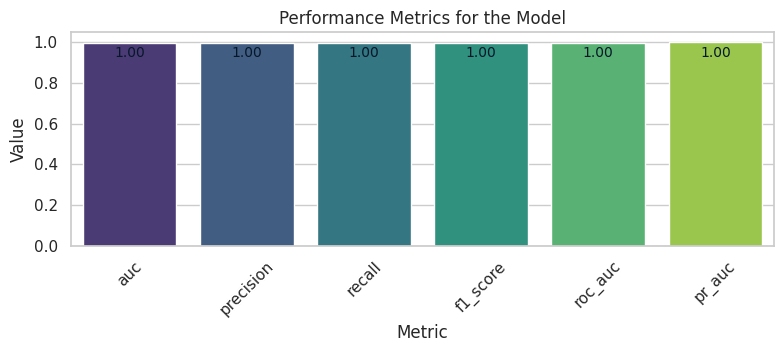

In [241]:
top_model_dict = select_top_best_models(metrics_dict=model_metrics, drop=False, top_n=1)
plot_performance_metrics(pd.DataFrame.from_dict(top_model_dict, orient='index'))

In [242]:
df_top_models = pd.DataFrame(top_model_dict).T
df_top_models.reset_index(inplace=True)
df_top_models.rename(columns={'index': 'Model'}, inplace=True)

Selected top model: CNN_reg_dropout
Model metrics:
y_pred: [1 0 1 ... 1 1 0]
y_probs: [9.9981368e-01 3.3644566e-04 9.9998707e-01 ... 9.9977189e-01 9.9833685e-01
 3.1065373e-04]
auc: 0.9994986346747841
precision: 0.9955089820359282
recall: 0.9962546816479401
f1_score: 0.9958816922500936
roc_auc: 0.9951392930152051
pr_auc: 0.9997246349462716
log_loss: 0.014827902505575582
Score: 0.6647249551908117
Selected top model: CNN_noise
Model metrics:
y_pred: [1 0 1 ... 1 1 0]
y_probs: [9.9999833e-01 9.8327735e-05 9.9999851e-01 ... 9.9999642e-01 9.9997425e-01
 1.7046810e-05]
auc: 0.999808257606279
precision: 0.9940074906367041
recall: 0.9940074906367041
f1_score: 0.9940074906367041
roc_auc: 0.9930196815733321
pr_auc: 0.9998589523021305
log_loss: 0.020177216029920706
Score: 0.6639607197510417
Selected top model: CNN_reg_noise
Model metrics:
y_pred: [1 0 1 ... 1 1 0]
y_probs: [9.9996173e-01 2.3006387e-04 9.9997157e-01 ... 9.9981922e-01 9.9969065e-01
 1.7430949e-04]
auc: 0.9997112672903891
precision:

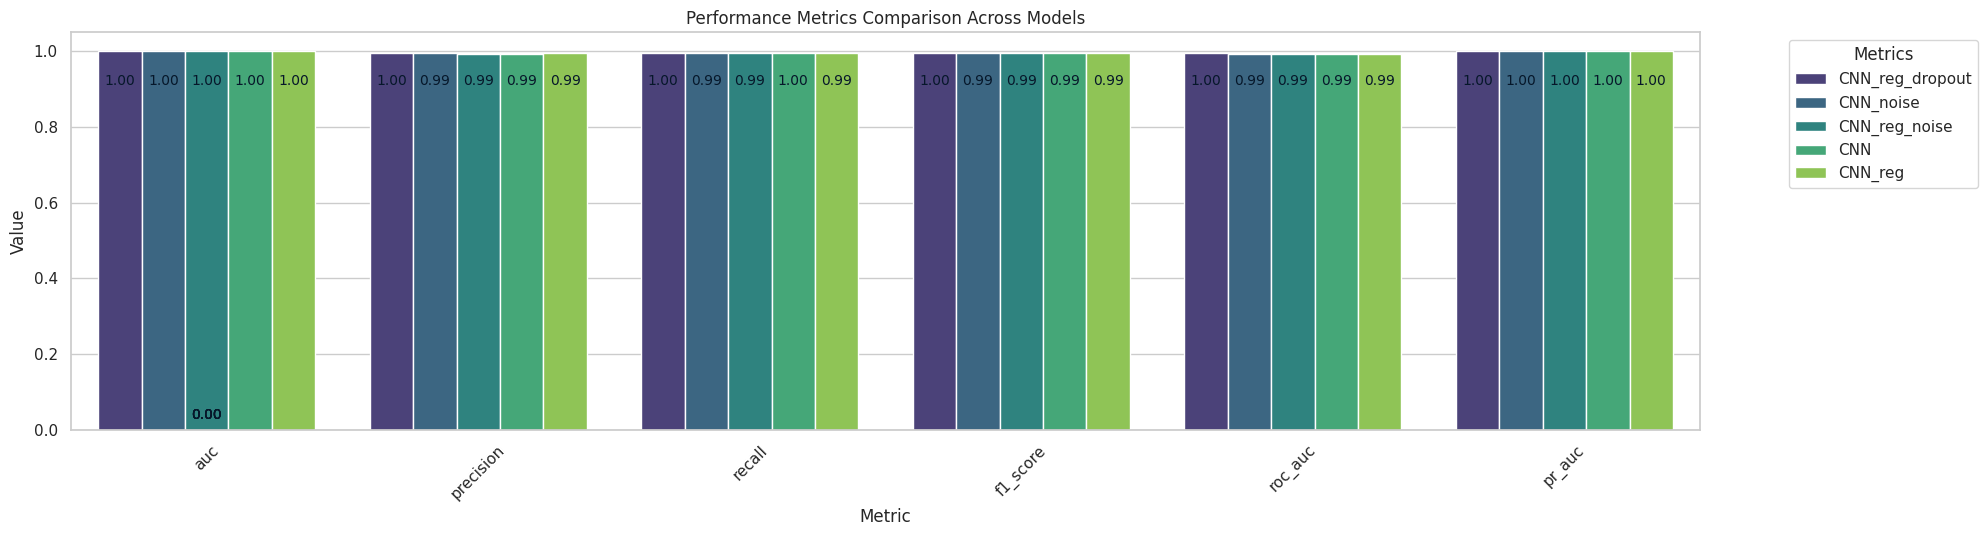

In [244]:
top_5_model_of_all = select_top_best_models(metrics_dict=model_metrics_temp, drop=False, top_n=5)
plot_performance_metrics(pd.DataFrame.from_dict(top_5_model_of_all, orient='index'))

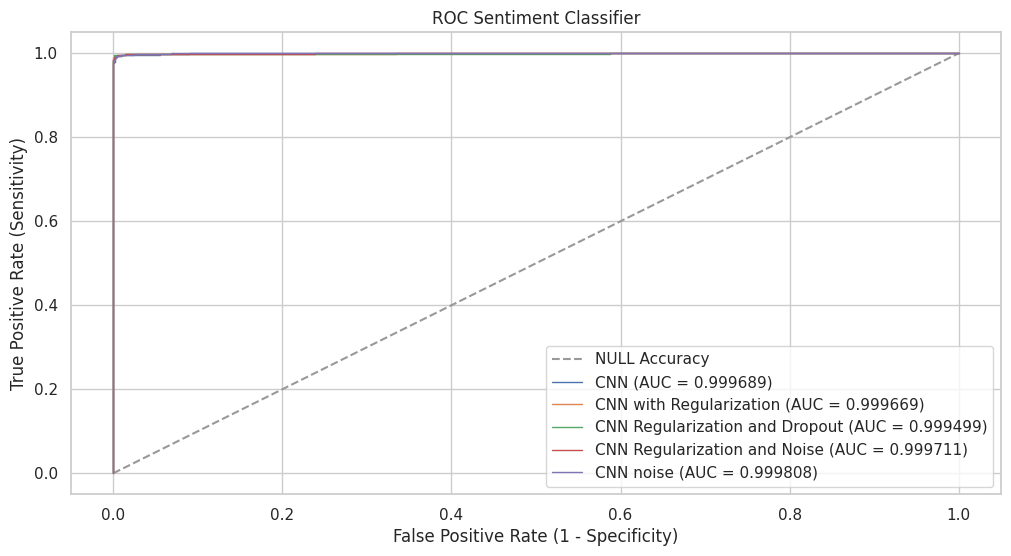

In [245]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='CNN (AUC = %0.6f)' % roc_auc_cnn)
plt.plot(fpr_cnn_reg, tpr_cnn_reg, lw=1, label='CNN with Regularization (AUC = %0.6f)' % roc_auc_cnn_reg)
plt.plot(fpr_cnn_cnn_reg_dropout, tpr_cnn_reg_dropout, lw=1, label='CNN Regularization and Dropout (AUC = %0.6f)' % roc_auc_cnn_reg_dropout)
plt.plot(fpr_cnn_reg_noise, tpr_cnn_reg_noise, lw=1, label='CNN Regularization and Noise (AUC = %0.6f)' % roc_auc_cnn_reg_noise)
plt.plot(fpr_cnn_noise, tpr_cnn_noise, lw=1, label='CNN noise (AUC = %0.6f)' % roc_auc_cnn_noise)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

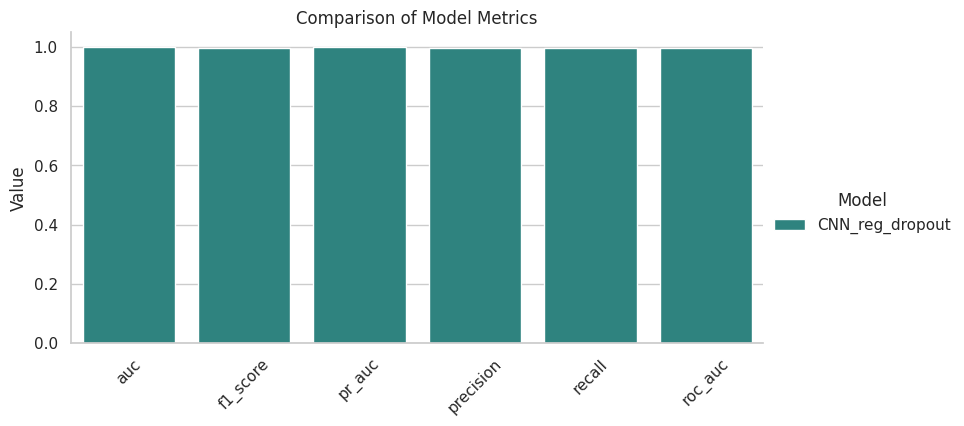

In [248]:
columns_to_exclude = ['y_pred', 'y_probs', 'log_loss', 'Score']

columns_to_visualize = [col for col in df_top_models.columns if col not in columns_to_exclude]

df_plot = df_top_models.melt(id_vars=['Model'], value_vars=columns_to_visualize, var_name='Metric', value_name='Value')

g = sns.catplot(x='Metric', y='Value', hue='Model', data=df_plot, kind='bar', palette='viridis', height=4, aspect=2)
g.set_xticklabels(rotation=45)
g.set_axis_labels("", "Value")
g._legend.set_title('Model')
plt.title('Comparison of Model Metrics')
plt.show()

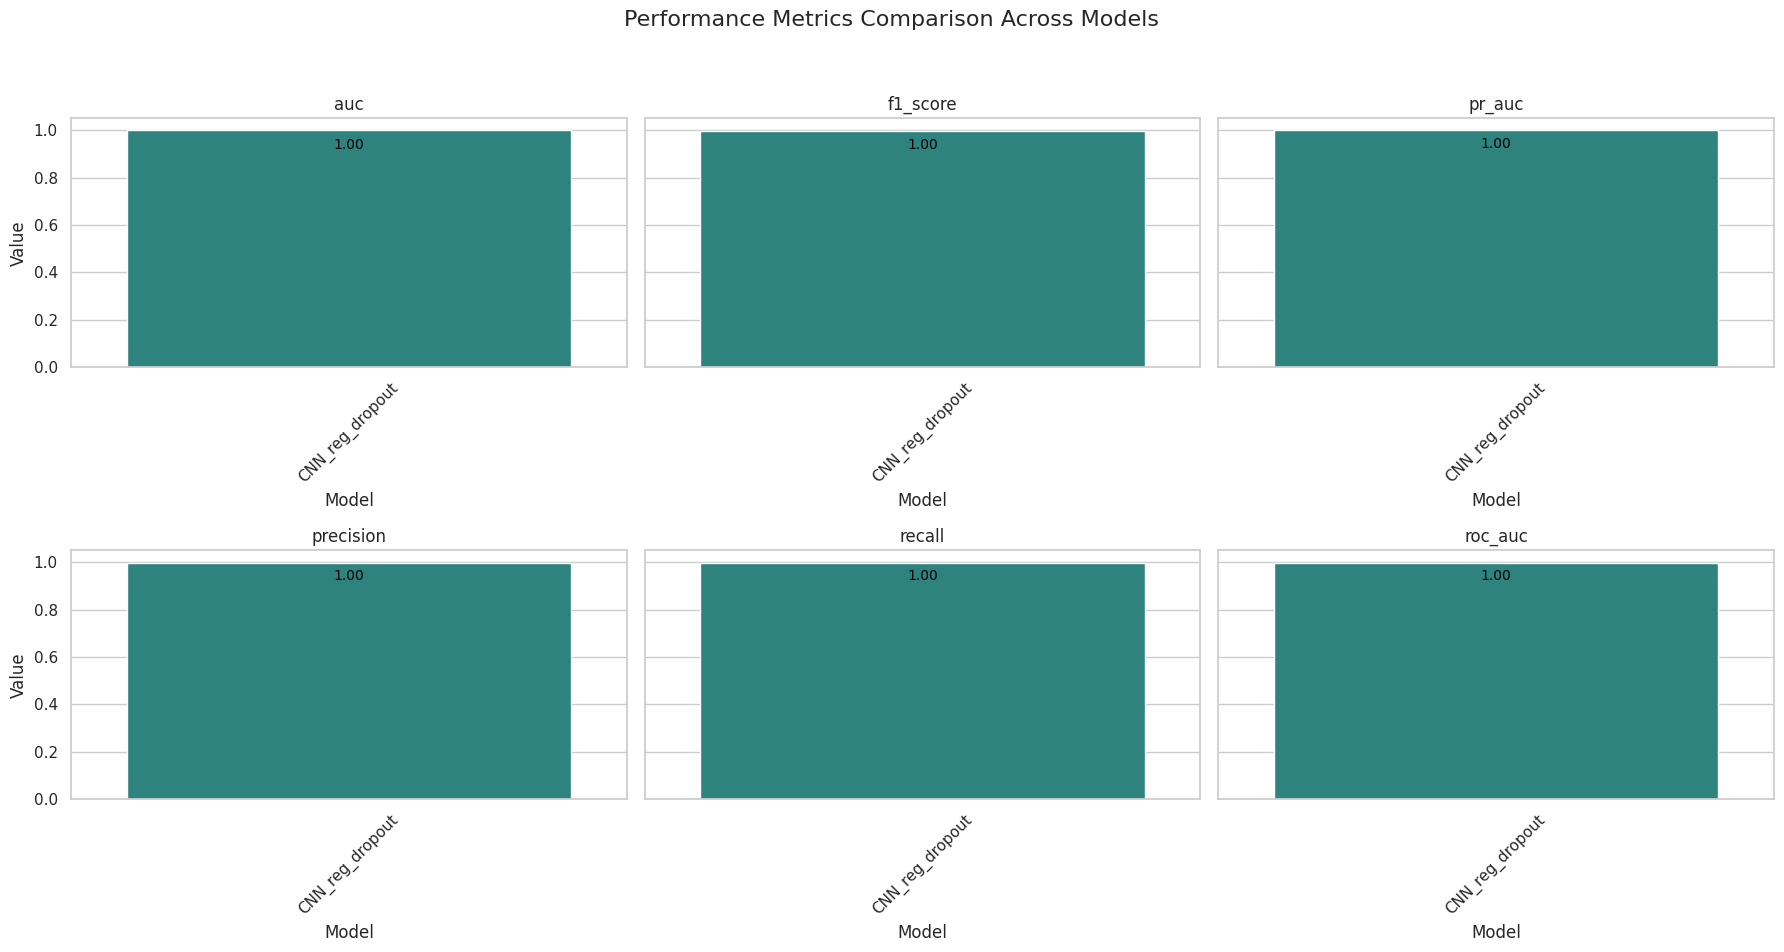

In [249]:
# Suppress future warnings locally
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Transpose the DataFrame for easier plotting of metrics (skipping specific columns)
    df_plot = df_top_models.set_index('Model').drop(columns=['y_pred', 'y_probs', 'Score', 'log_loss']).transpose()

    # Define the layout of the subplots
    num_metrics = len(df_plot)
    num_columns = 3
    num_rows = (num_metrics + num_columns - 1) // num_columns  # Round up the division

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 5), sharey=True)
    fig.suptitle('Performance Metrics Comparison Across Models', fontsize=16)

    # Flatten axes array and hide unused axes
    axes = axes.flatten()
    for ax in axes[num_metrics:]:
        ax.set_visible(False)

    # Loop through each metric and create a bar plot
    for ax, (metric, values) in zip(axes, df_plot.iterrows()):
        sns.barplot(ax=ax, x=values.index, y=values.values, palette='viridis', width=0.8)
        ax.set_title(metric)
        ax.set_ylabel('Value')
        ax.set_xlabel('Model')
        ax.tick_params(axis='x', rotation=45)

        # Adjusting the annotation placement
        for p in ax.patches:
            value = p.get_height()
            x = p.get_x() + p.get_width() / 2
            # Adjusting y to ensure the annotation always fits within the plot area
            if value >= ax.get_ylim()[1] * 0.9:  # If value is within the top 10% of the y-axis
                y = ax.get_ylim()[1] * 0.85  # Lower the annotation to 85% of the y-axis height
            else:
                y = value + 0.01 * ax.get_ylim()[1]  # Else, slightly above the bar
            ax.annotate(f"{value:.2f}", (x, y), ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')

    # Adjust layout to prevent label overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot
    plt.show()


In [250]:
best_final_model = None

def load_model_global(model_path):
    global best_final_model
    if os.path.isdir(model_path):
        # Assuming it's a Keras SavedModel directory
        try:
            best_final_model = load_model(model_path)
            print(f"Model loaded from {model_path}.")
        except Exception as e:
            print(f"Failed to load Keras model from {model_path}: {e}")
    else:
        # Assuming it's a pickle file
        try:
            with open(model_path, 'rb') as file:
                best_final_model = pickle.load(file)
            print(f"Model loaded from {model_path}.")
        except Exception as e:
            print(f"Failed to load pickle model from {model_path}: {e}")

def predict_with_best_final_model(model, data, tokenizer=None, max_length=None):
    if hasattr(model, 'predict'):
        # This branch is for Keras models
        if tokenizer is not None and max_length is not None:
            # Assume it's a Keras model expecting tokenized input
            sequences = tokenizer.texts_to_sequences(data['comment'])
            X_test_new = pad_sequences(sequences, maxlen=max_length)
            y_pred_prob = model.predict(X_test_new).flatten()
            y_pred = (y_pred_prob > 0.5).astype(int)
            return y_pred, y_pred_prob
        else:
            print("Tokenizer and max_length must be provided for Keras models.")
            return None, None
    elif hasattr(model, 'predict_proba'):
        # This branch is for sklearn models
        y_pred = model.predict(data)
        y_pred_prob = model.predict_proba(data)[:, 1]
        return y_pred, y_pred_prob
    else:
        print("Model type not supported for predictions.")
        return None, None


# Load the final model
final_model_path = 'models/CNN'  # Adjust this path to your model's location
load_model_global(final_model_path)

# Predict with the Keras model
comments = test_data_df  # DataFrame containing the comments
y_pred, y_pred_prob = predict_with_best_final_model(best_final_model, comments, tokenizer, max_length)


Model loaded from models/CNN.
1033/1033 [==============================] - 4s 4ms/step


In [251]:
# Create a DataFrame with comments and their predicted classes
predictions_df = pd.DataFrame({
    'comment': test_data_df['comment'],
    'predicted_class': y_pred
})

# Filter comments into two separate groups
negative_comments = predictions_df[predictions_df['predicted_class'] == 0]['comment']
positive_comments = predictions_df[predictions_df['predicted_class'] == 1]['comment']


In [252]:
predictions_df

comment  predicted_class
0      " I don't care what anyone says, I like Hillar...                0
1                      have an awesome time at purdue!..                1
2      Yep, I'm still in London, which is pretty awes...                1
3      Have to say, I hate Paris Hilton's behavior bu...                0
4                                i will love the lakers.                1
...                                                  ...              ...
33047             Love Story At Harvard [ awesome drama!                1
33048  well, i had a piece of crap toyota celica but ...                0
33049                                 But I miss Boston.                1
33050                              i love paris hilton..                1
33051  I was rejected by the stupid San Francisco lit...                0

[33052 rows x 2 columns]

Word Cloud for Negative Comments (Class 0):


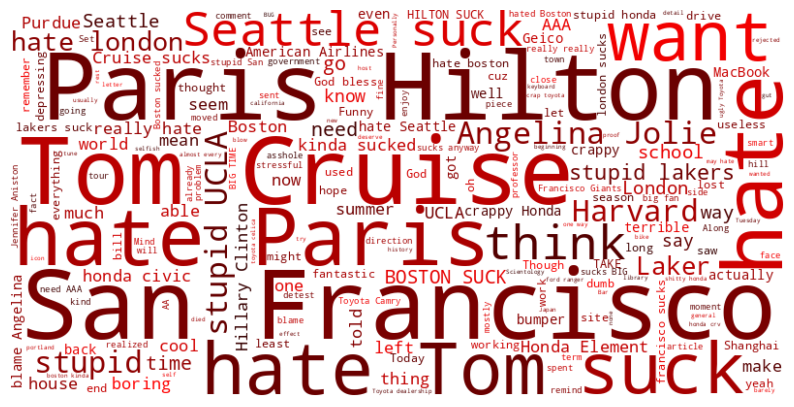

Word Cloud for Positive Comments (Class 1):


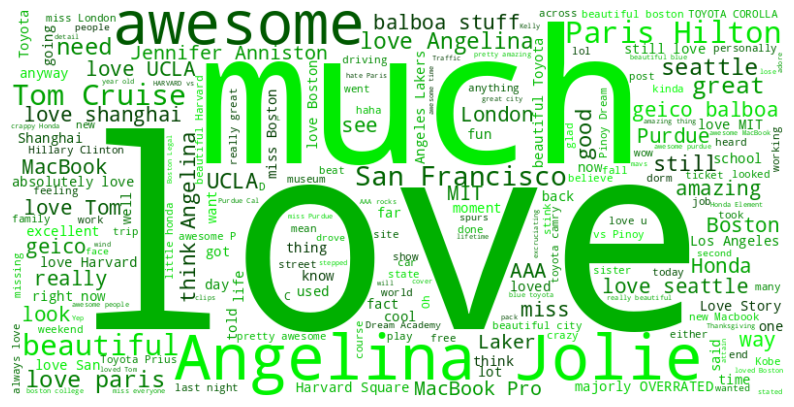

In [253]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the position in the list."""
    def __init__(self, color_to_words, default_color):
        self.color_to_words = color_to_words
        self.default_color = default_color

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        return get_single_color_func(self.color_to_words.get(word, self.default_color))

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

# Function to generate and display a word cloud with custom colors
def generate_wordcloud(text, color_to_words, default_color):
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white',
                          color_func=SimpleGroupedColorFunc(color_to_words, default_color)).generate(" ".join(text))
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Define colors for each word cloud
negative_color_to_words = {}
positive_color_to_words = {}

# Example: Assigning red shades for negative and green shades for positive
negative_default_color = 'darkred'  # Default color for words not in negative_color_to_words
positive_default_color = 'darkgreen'  # Default color for words not in positive_color_to_words

# Generate and display word cloud for negative comments
print("Word Cloud for Negative Comments (Class 0):")
generate_wordcloud(negative_comments, negative_color_to_words, negative_default_color)

# Generate and display word cloud for positive comments
print("Word Cloud for Positive Comments (Class 1):")
generate_wordcloud(positive_comments, positive_color_to_words, positive_default_color)


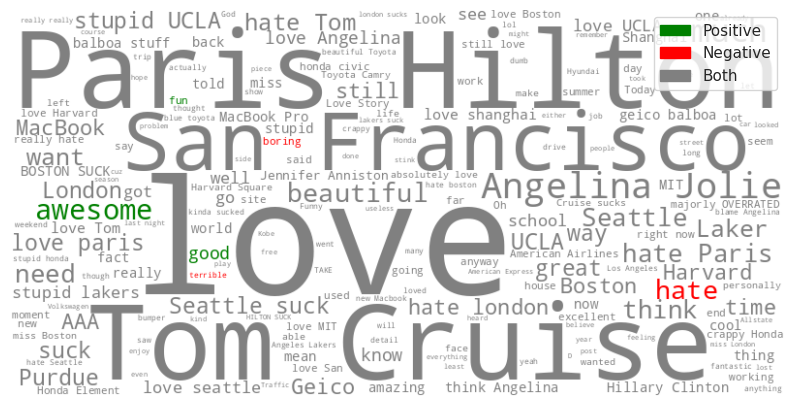

In [254]:
# Custom color function to apply colors based on word sentiment
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    positive_words = ['awesome', 'good', 'nice', 'super', 'fun', 'delightful', 'happy']  # Example positive words
    negative_words = ['hate', 'bad', 'awful', 'terrible', 'boring', 'sad', 'worse']  # Example negative words
    if word in positive_words:
        return 'green'
    elif word in negative_words:
        return 'red'
    else:
        return 'grey'  # Neutral color for words not specified

# Generate a combined word cloud
combined_comments = pd.concat([negative_comments, positive_comments])
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      color_func=color_func, prefer_horizontal=1.0).generate(" ".join(combined_comments))

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Create a legend for the colors
legend_handles = [mpatches.Patch(color='green', label='Positive'),
                  mpatches.Patch(color='red', label='Negative'),
                  mpatches.Patch(color='grey', label='Both')]
plt.legend(handles=legend_handles, loc='upper right')

plt.show()